# Introducción

En esta libreta de Jupyter se encuentra desglosado en código todo lo realizado y presentado para el trabajo escrito. Se respeta la enumeración que se lleva en el documento escrito.

# 0. Código 

Esta sección contiene las diferentes funciones y código que se usará a lo largo del proyecto

## 0.1 Importar Librerías y Funciones Varias

In [71]:
# Importar librerías

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm 

In [72]:
# Funcionalidades para Tipado

from typing import Callable

In [73]:
# Definiendo variables y constantes

Color_Palette = ['green','red','gold']
Color_Map = 'seismic'

Macronutrients = ['Carbs','Protein','Fat']
Diets = ['dash', 'keto', 'mediterranean', 'paleo', 'vegan']
Cuisine = 'Cuisine_type'
Diet = 'Diet_type'
Total = 'Total_Macronutrients'

MapTranslate = {
    'Carbs' : 'Carbohidratos',
    'Protein' : 'Proteínas',
    'Fat' : 'Grasas',
}
InverseMacronutrient = {
    'Carbs' : 0,
    'Protein' : 1,
    'Fat' : 2,
}

RANDOM_STATE = 8013

In [74]:
def __CreateMosaicPlot():
    """
        Function for creating the fig
        for plots
    """
    Display = "PPCC\n.FF."

    fig , axes = plt.subplot_mosaic(Display,figsize=(12,8),layout='tight',subplot_kw={'xlim':(0-1e-2,1+1e-2)})
    ConfigPlot = zip(Macronutrients,['C','P','F'],Color_Palette)

    return fig , axes , ConfigPlot

def __OrderDiets(Dataset:pd.DataFrame,Macronutrient:str) -> np.ndarray:
    return Dataset[Macronutrient].quantile(0.25).sort_values().index

def __SetLabelsPlot(ax,Title:str,XLabel:str=None,YLabel:str=None) -> None:
    if Title : ax.set_title(Title,size=18)
    if XLabel : ax.set_xlabel(XLabel,size=14)
    if YLabel : ax.set_ylabel(YLabel,size=14)
    ax.tick_params(labelsize=12)

def __SetTitleFig(fig,Title:str) -> None:
    fig.suptitle(Title,size=30)

In [75]:
def Plot_DistributionMacronutrients(Diets_Dataset:pd.DataFrame):
    """
        Función para gráficar los gráficos de tipo cajas y bigotes 
        por cada macronutriente.
    """
    fig , axes , ConfigPlot = __CreateMosaicPlot()
    for macronutrient , display , color in ConfigPlot:
        sns.boxplot(data=Diets_Dataset,x=macronutrient,ax=axes[display],color=color)
        __SetLabelsPlot(axes[display],MapTranslate[macronutrient],'Porcentaje de Gramos')

    __SetTitleFig(fig,'Distribución de Macronutrientes')

    return fig

In [76]:
def Plot_MacronutientsByDiet_Histogram(Diets_Dataset:pd.DataFrame,Diet:str) -> None:
    """
        Función para gráficar los histogramas de los macronutrientes 
        para dieta en específico.
    """
    diet_type_dataset = Diets_Dataset.query("Diet_type == @Diet")
    def PlotMacronutients():
        fig , axes , ConfigPlot = __CreateMosaicPlot()
        for macronutrient , display , color in ConfigPlot:
            sns.histplot(data=diet_type_dataset,x=macronutrient,ax=axes[display],stat='proportion',bins=25,color=color)
            __SetLabelsPlot(axes[display],MapTranslate[macronutrient],'Porcentaje de Gramos','Proporción')

        __SetTitleFig(fig,f'Dieta: {Diet}')

    PlotMacronutients()

In [77]:
def Plot_MacronutrientsByDiet_Boxplot(Diets_Dataset:pd.DataFrame) -> None:
    """
        Función para gráficar las boxplots de los macronutrientes por 
        dieta.
    """
    fig , axes , ConfigPlot = __CreateMosaicPlot()
    for macronutrient , display , color in ConfigPlot:
        order_diets = __OrderDiets(Diets_Dataset.groupby(Diet),macronutrient)
        sns.boxplot(data=Diets_Dataset,x=macronutrient,y='Diet_type',ax=axes[display],color=color,order=order_diets)
        __SetLabelsPlot(axes[display],MapTranslate[macronutrient],'Porcentaje de Gramos','Tipo de Dieta')
    
    __SetTitleFig(fig,'Distribución de Macronutrientes por Dieta')

In [220]:
from itertools import combinations

def Plot_BiMacronutrients(Diets_Dataset:pd.DataFrame,Diet:str='General') -> None:
    """
        Función para gráficar el plot de dispersión entre 
        los macronutrientes
    """
    data_diet = Diets_Dataset.query("Diet_type == @Diet") if Diet != 'General' else Diets_Dataset

    Display = "PPCC\n.FF."
    _margin = 3e-2
    fig , axes = plt.subplot_mosaic(Display,figsize=(12,8),layout='tight',subplot_kw={'xlim':(0-_margin,1+_margin),'ylim':(0-_margin,1+_margin)})
    for (macronutrient_1 , macronutrient_2) ,  display in zip(combinations(Macronutrients,2),['C','P','F']):
        sns.regplot(data_diet,x=macronutrient_1,y=macronutrient_2,ax=axes[display],
                    scatter_kws={'alpha':0.1,'linewidths':0,'color':'#337BF5'},
                    line_kws={'color':'black'})
    
        x_label = MapTranslate[macronutrient_1]
        y_label = MapTranslate[macronutrient_2]
        rho = data_diet[[macronutrient_1,macronutrient_2]].corr().iloc[0,1]
        __SetLabelsPlot(axes[display],f'{x_label} contra {y_label}\n'+rf'$\rho$={rho:.4f}',x_label,y_label)

    __SetTitleFig(fig,f'Correlación entre Macronutrientes en {Diet}')

In [78]:
def PlotMacronutrientsByCuisine(Diets_Dataset:pd.DataFrame,Diet:str,Macronutrient:str) -> None:
    """
        Función para graficar los macronutrientes de una dieta sobre 
        las diferentes cocinas
    """
    fig , axes = plt.subplots(figsize=(8,12))

    dataset_diet =  Diets_Dataset.query("Diet_type == @Diet").copy() if Diet else Diets_Dataset.copy()
    dataset_by_cuisine = dataset_diet.groupby(Cuisine)[Macronutrient]

    order_country = dataset_by_cuisine.quantile(0.25).sort_values().index

    medians_over_cuisine = dataset_by_cuisine.median()
    quartiles_medians_cuisine = medians_over_cuisine.quantile([0.25,0.5,0.75]).to_numpy()
    interval_medians_over_cuisine = quartiles_medians_cuisine.searchsorted(medians_over_cuisine)
    country_median_mark = pd.Series(interval_medians_over_cuisine,index=medians_over_cuisine.index)
    dataset_diet['interval_median'] = country_median_mark.loc[dataset_diet[Cuisine]].values

    color_macronutrient = Color_Palette[InverseMacronutrient[Macronutrient]]
    sns.boxplot(dataset_diet,x=Macronutrient,y=Cuisine,hue='interval_median',order=order_country,palette=f'light:{color_macronutrient}',legend=False,ax=axes)
    axes.set_xlim(0-1e-2,1+1e-2)

    __SetLabelsPlot(axes,None,MapTranslate[Macronutrient],'Tipo de Cocina')
    title_base = f'Distribución de {MapTranslate[Macronutrient]} sobre\n Tipo de Cocina'
    title_base += f' en {Diet}' if Diet else ''
    __SetTitleFig(fig,title_base)

In [199]:
def PlotMacronutrientsCorreologram(Diets_Dataset:pd.DataFrame,Diet:str='General') -> None:
    """
        Función para gráficar el correleograma de los 
        macronutrientes de las recetas de una dieta 
        específica
    """
    fig , axes = plt.subplots(figsize=(9,8),layout='tight')

    recipes_diet = Diets_Dataset.query("Diet_type == @Diet")[Macronutrients] if Diet != 'General' else Diets_Dataset[Macronutrients]
    corr_matrix = recipes_diet.corr()

    sns.heatmap(corr_matrix,vmin=-1,vmax=1,annot=True,cmap=Color_Map,ax=axes,annot_kws={'size':14},linecolor='white',linewidths=4)
    __SetLabelsPlot(axes,'','Macronutrientes','Macronutrientes')
    axes.set_xticklabels(MapTranslate.values())
    axes.set_yticklabels(MapTranslate.values())
    __SetTitleFig(fig,f'Correolograma de los\nMacronutrientes en {Diet}')

In [80]:
def PlotQQByDiet(Diets_Dataset:pd.DataFrame,Diet:str) -> None:
    """
        Función para generar los q-q plots por macronutrient
    """
    dataset_diet = Diets_Dataset.query("Diet_type == @Diet")[Macronutrients]

    fig , axes , ConfigPlot = __CreateMosaicPlot()
    fig.set_size_inches(10,9)
    for macronutrient , display , color in ConfigPlot:
        filtered_dataset = dataset_diet[macronutrient]
        filtered_dataset = filtered_dataset[(filtered_dataset < 1) & (filtered_dataset > 0)]

        fitted_dist_args = stats.beta.fit(filtered_dataset,floc=0,fscale=1)
        (theoretical_quantiles , sample_quantiles) , _ = stats.probplot(filtered_dataset,dist=stats.beta,sparams=fitted_dist_args)
        
        axes[display].scatter(theoretical_quantiles,sample_quantiles,s=5,c=color)
        axes[display].plot(theoretical_quantiles,theoretical_quantiles,color='black',alpha=0.5,linestyle='--',lw=3)
        
        __SetLabelsPlot(axes[display],f'{MapTranslate[macronutrient]} fitted con\n'+rf'$\alpha$={fitted_dist_args[0]:.4f} y $\beta$={fitted_dist_args[1]:.4f}','Percentiles Teóricos','Percentiles Muestrales')
    
    __SetTitleFig(fig,f'Distribución de Macronutrientes en\n{Diet.capitalize()}')

In [81]:
def SummaryMeasures(Dataset_Sample:pd.DataFrame) -> pd.DataFrame:
    """
        Función para calcular la media, Q1, Q2, Q3, desviación 
        estándar, mínimo, máximo y asimetría de Fisher de un 
        conjunto de datos sobre ciertos atributos
    """
    measures = ['mean','25%','50%','75%','std','min','max']
    
    summary_measures = Dataset_Sample[Macronutrients].describe().loc[measures]
    summary_measures.loc['skewness'] = Dataset_Sample[Macronutrients].skew()

    return summary_measures

In [82]:
def Frequencies_Sample(Sample:pd.DataFrame,Variable:str) -> pd.DataFrame:
    """
        Función para obtener las frecuencias relativas, absoluta y acumulada 
        de una muestra en base a un atributo/variable continua. 
    """
    frequency_absolute , bins_classes = np.histogram(Sample[Variable],bins=7)

    frequency_random = []
    frequency_random.append(frequency_absolute)
    frequency_random.append(frequency_absolute/50)
    frequency_random.append(np.cumulative_sum(frequency_absolute)/50)

    class_marks = (bins_classes[:-1]+bins_classes[1:])/2
    
    sampling_mean = Sample[Variable].mean()
    sampling_std = Sample[Variable].std()
    frequency_random.append((class_marks-sampling_mean)/sampling_std)

    frequency_random = pd.DataFrame(frequency_random,index=['Frequency_absolute','Frequency_relative','Frequency_cumulative','Z-Score'],columns=class_marks).T
    frequency_random.rename_axis(index='Class_mark',columns='Frequencies',inplace=True)

    return frequency_random

In [83]:
def ZScores_Sample(Sample:pd.DataFrame,Variable:str) -> pd.DataFrame:
    """
        Función para determinar los puntajes Z de cada valor 
        perteneciente a una muestra.
    """
    values = Sample[Variable]
    z_scores = (values-values.mean())/values.std()

    summary_data = pd.concat([values,z_scores],ignore_index=True,axis=1)
    summary_data.rename(columns=dict(zip(range(2),['Value','ZScore'])),inplace=True)
    return summary_data

In [84]:
def Show_ConfidenceIntervals(Data_Sample:np.ndarray,ConfidenceLevels:list[float],ConfidenceIntervalConstruct:Callable) -> pd.DataFrame:
    """
        Función para construir una tabla para mostrar 
        los resultados de los intervalos de confianza 
        construidos en base a ciertos niveles de 
        confianza y construcción
    """
    confidence_intervals = []
    for confidence_level in ConfidenceLevels:
        confidence_interval = ConfidenceIntervalConstruct(Data_Sample,confidence_level)
        confidence_intervals.append((confidence_level,*confidence_interval))

    table_results = pd.DataFrame(confidence_intervals,columns=['Confidence Level','Lower Bound','Upper Bound'])
    return table_results.set_index('Confidence Level')

def ConfidenceIntervalPopulationMean(Data_Sample:np.ndarray,Confidence:float) -> tuple[float,float]:
    """
        Función para obtener el intervalo de confianza 
        para la media poblacional a partir de una confianza 
        dada y un muestreo.
    """
    size_sample = Data_Sample.size
    mean_sample = np.mean(Data_Sample)
    std_sample = np.std(Data_Sample,ddof=1)

    return norm.interval(Confidence,mean_sample,std_sample/np.sqrt(size_sample))

## 0.2 Carga de Datos

In [85]:
# Carga de datos

macronutrients = ['Carbs(g)','Protein(g)','Fat(g)']

Diets_Dataset = pd.read_csv('../Datasets/Diets_Dataset.csv')
Diets_Dataset.drop(columns=['Extraction_day','Extraction_time'],inplace=True)
Diets_Dataset.rename(columns={macronutrient : macronutrient[:-3] for macronutrient in macronutrients},inplace=True)

# 4. Presentación de los Datos

In [86]:
# Ejemplos de registros del conjunto de datos

Diets_Dataset

,Diet_type,Recipe_name,Cuisine_type,Protein,Carbs,Fat
0,paleo,Bone Broth From 'Nom Nom Paleo',american,5.22,1.29,3.20
1,paleo,"Paleo Effect Asian-Glazed Pork Sides, A Sweet ...",south east asian,181.55,28.62,146.14
2,paleo,Paleo Pumpkin Pie,american,30.91,302.59,96.76
3,paleo,Strawberry Guacamole recipes,mexican,9.62,75.78,59.89
4,paleo,"Asian Cauliflower Fried ""Rice"" From 'Nom Nom P...",chinese,39.84,54.08,71.55
...,...,...,...,...,...,...
7801,dash,Brown Butter-Sunchoke Soup With Brussels Sprou...,italian,85.20,288.14,137.15
7802,dash,Make-Your-Own-Salad,american,141.98,123.18,323.50
7803,dash,Luis Buñuel Dry Martini,world,0.01,0.39,0.00
7804,dash,Cornflake Semi-Fried Chicken Tenders,american,155.38,239.88,260.84


In [87]:
# Valore únicos por variable en el conjunto de datos

Diets_Dataset.apply(lambda column: len(pd.Series.unique(column)),axis=0)

Diet_type          5
Recipe_name     7062
Cuisine_type      19
Protein         6060
Carbs           6618
Fat             6322
dtype: int64

# 5. Estadística Descriptiva

## 5.1 Transformación de Datos

Como se mencionó en el documento escrito, de cada receta, los valores de sus aportes nutricionales son normalizados usando el total de macronutrientes que aporta cada receta.

In [88]:
# Total de macronutrientes por receta

Diets_Dataset[Total] = Diets_Dataset[Macronutrients].apply(sum,axis=1)

In [89]:
# Normalización de cada valor de macronutriente

for macronutrient in Macronutrients:
    Diets_Dataset[macronutrient] /= Diets_Dataset[Total]

In [90]:
print(Diets_Dataset.groupby(Diet)[Macronutrients+[Total]].sample(1,random_state=RANDOM_STATE).to_latex())

\begin{tabular}{lrrrr}
\toprule
 & Carbs & Protein & Fat & Total_Macronutrients \\
\midrule
7233 & 0.985714 & 0.012245 & 0.002041 & 9.800000 \\
3139 & 0.099781 & 0.233406 & 0.666813 & 91.300000 \\
4326 & 0.296537 & 0.250773 & 0.452690 & 32.340000 \\
88 & 0.372401 & 0.224681 & 0.402918 & 104.860000 \\
2316 & 0.470311 & 0.105648 & 0.424041 & 165.550000 \\
\bottomrule
\end{tabular}



## 5.3 Visión General de los Datos

In [91]:
# Calculo de las medidas de tendencia central, dispersión y asimetría 

SummaryMeasures(Diets_Dataset)

,Carbs,Protein,Fat
mean,0.433471,0.234762,0.331767
25%,0.205251,0.110188,0.184583
50%,0.432028,0.190931,0.314359
75%,0.635058,0.338059,0.464532
std,0.256032,0.163886,0.194920
min,0.000330,0.000000,0.000000
max,1.000000,0.887557,0.997940
skewness,0.189556,0.922401,0.461455


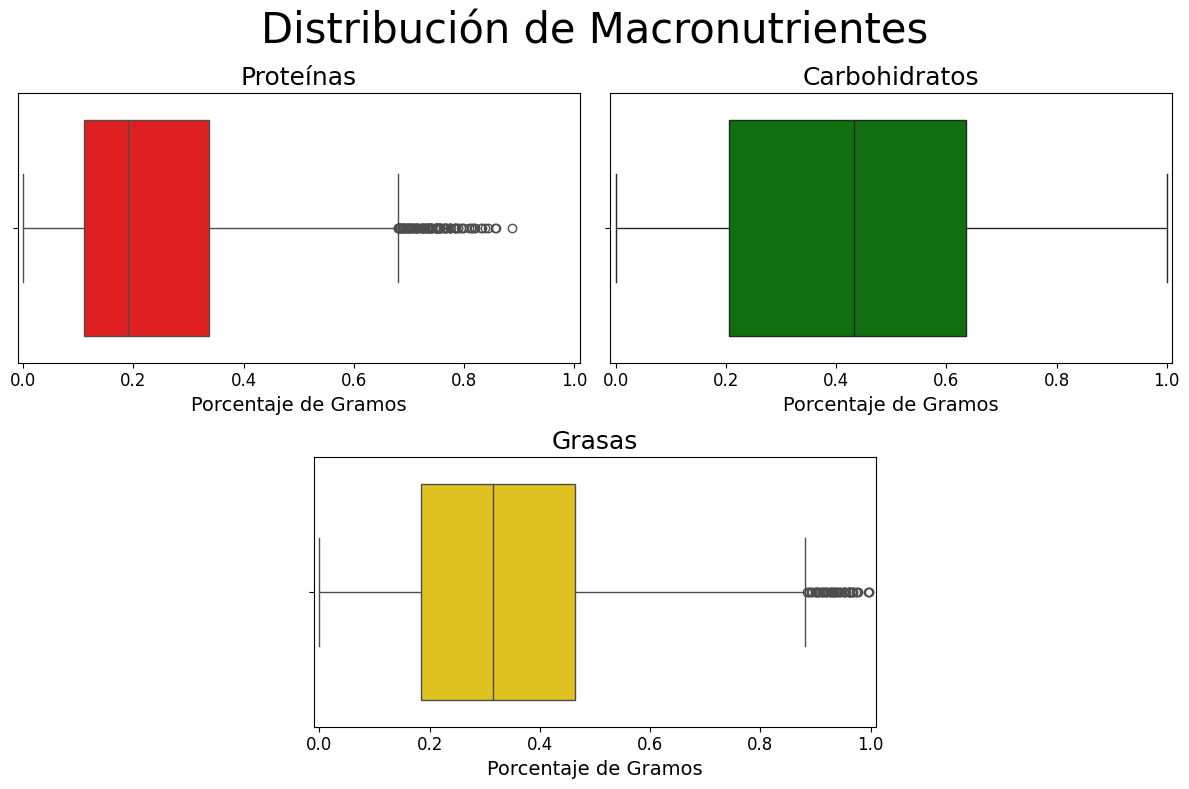

In [92]:
# Plot de la distribución de los macronutrientes

_ = Plot_DistributionMacronutrients(Diets_Dataset)

In [93]:
# Recetas por tipo de Dieta y Cocina

Diets_Dataset.pivot_table(values='Recipe_name',index=Cuisine,columns=Diet,aggfunc='count',margins=True)

Diet_type,dash,keto,mediterranean,paleo,vegan,All
Cuisine_type,,,,,,
american,639.0,663.0,145.0,535.0,925.0,2907
asian,24.0,11.0,12.0,12.0,67.0,126
british,64.0,90.0,4.0,54.0,27.0,239
caribbean,3.0,7.0,1.0,6.0,1.0,18
central europe,9.0,11.0,1.0,9.0,4.0,34
chinese,38.0,38.0,1.0,26.0,17.0,120
eastern europe,10.0,11.0,3.0,27.0,4.0,55
french,150.0,163.0,61.0,154.0,76.0,604
indian,20.0,12.0,3.0,9.0,48.0,92


### Macronutrientes por Tipo de Cocina

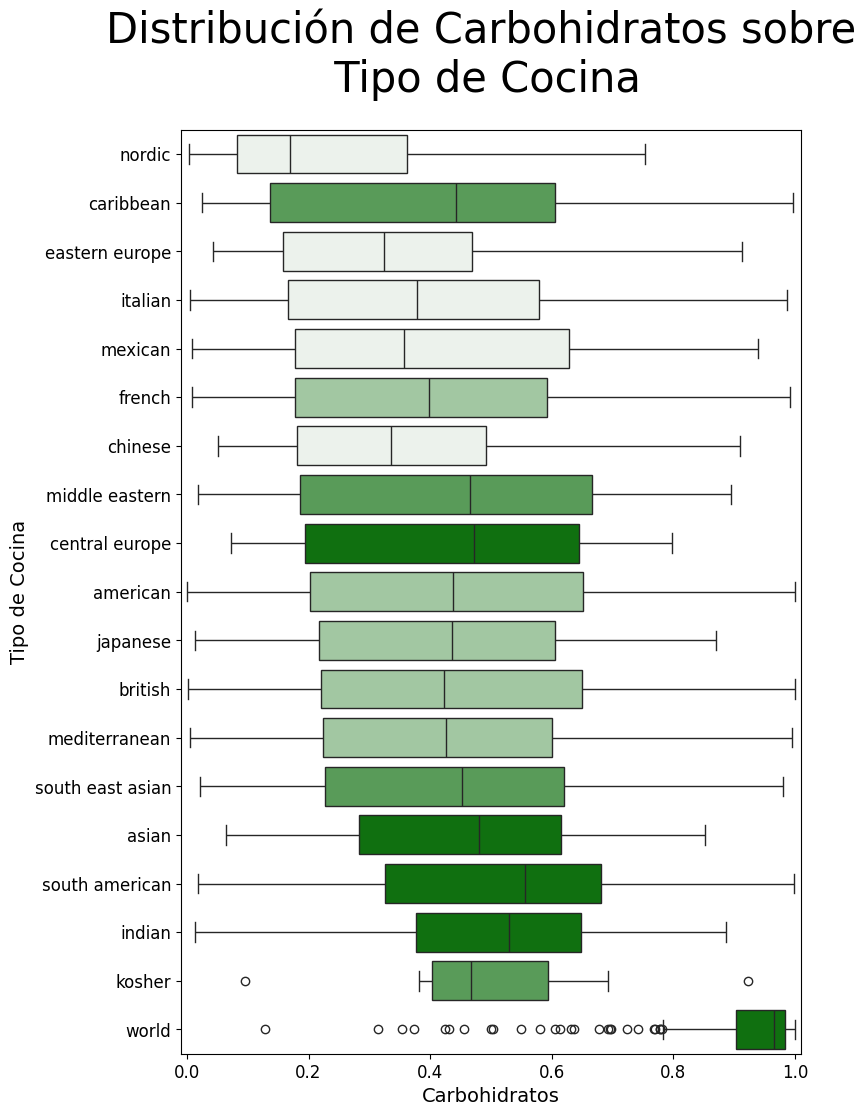

In [94]:
# Carbohidratos por país

PlotMacronutrientsByCuisine(Diets_Dataset,None,Macronutrients[0])

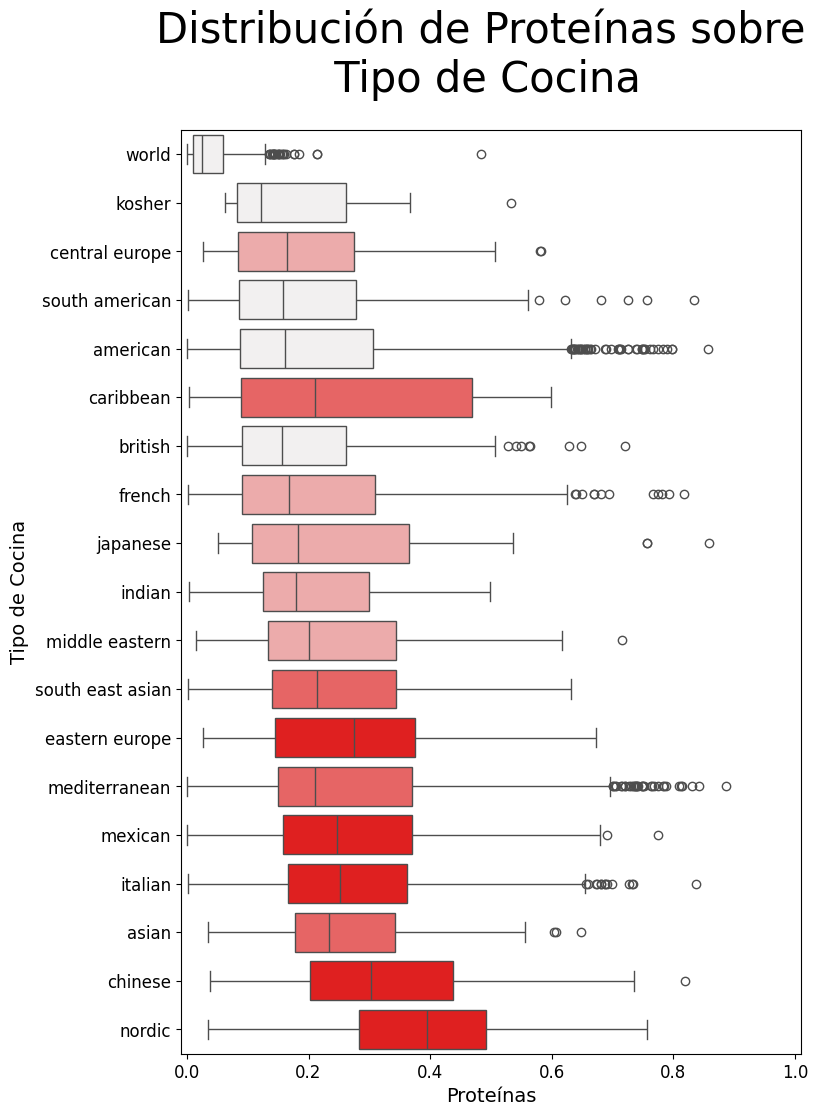

In [95]:
# Proteínas por país

PlotMacronutrientsByCuisine(Diets_Dataset,None,Macronutrients[1])

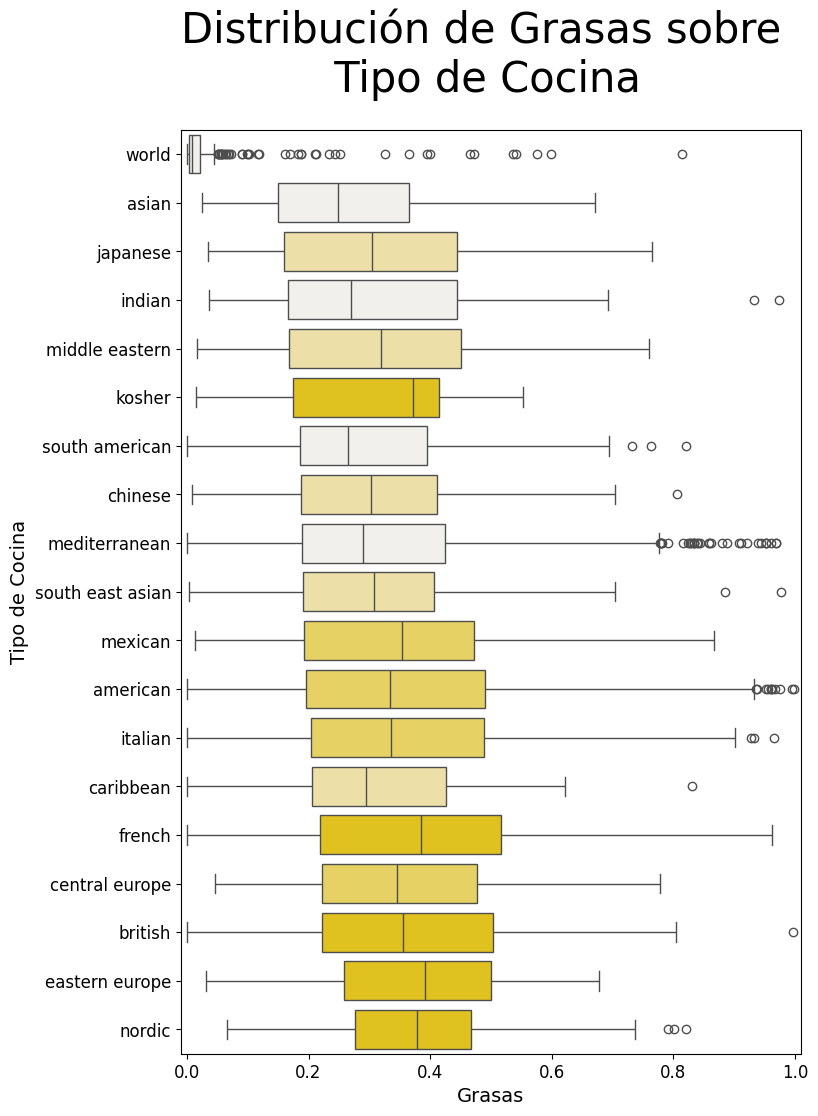

In [96]:
# Grasas por país

PlotMacronutrientsByCuisine(Diets_Dataset,None,Macronutrients[2])

## 5.4 Estratificación de Valores Cuantitativos

### 5.4.1 Dieta DASH

In [97]:
diet = Diets[0]

print(f'Dieta: {diet}')
SummaryMeasures(Diets_Dataset.query("Diet_type == @diet"))

Dieta: dash


,Carbs,Protein,Fat
mean,0.549425,0.196241,0.254334
25%,0.331143,0.068931,0.103381
50%,0.555219,0.156626,0.234742
75%,0.757917,0.282629,0.371292
std,0.278850,0.162871,0.194078
min,0.001526,0.000000,0.000000
max,1.000000,0.833467,0.973404
skewness,-0.057984,1.101171,0.732534


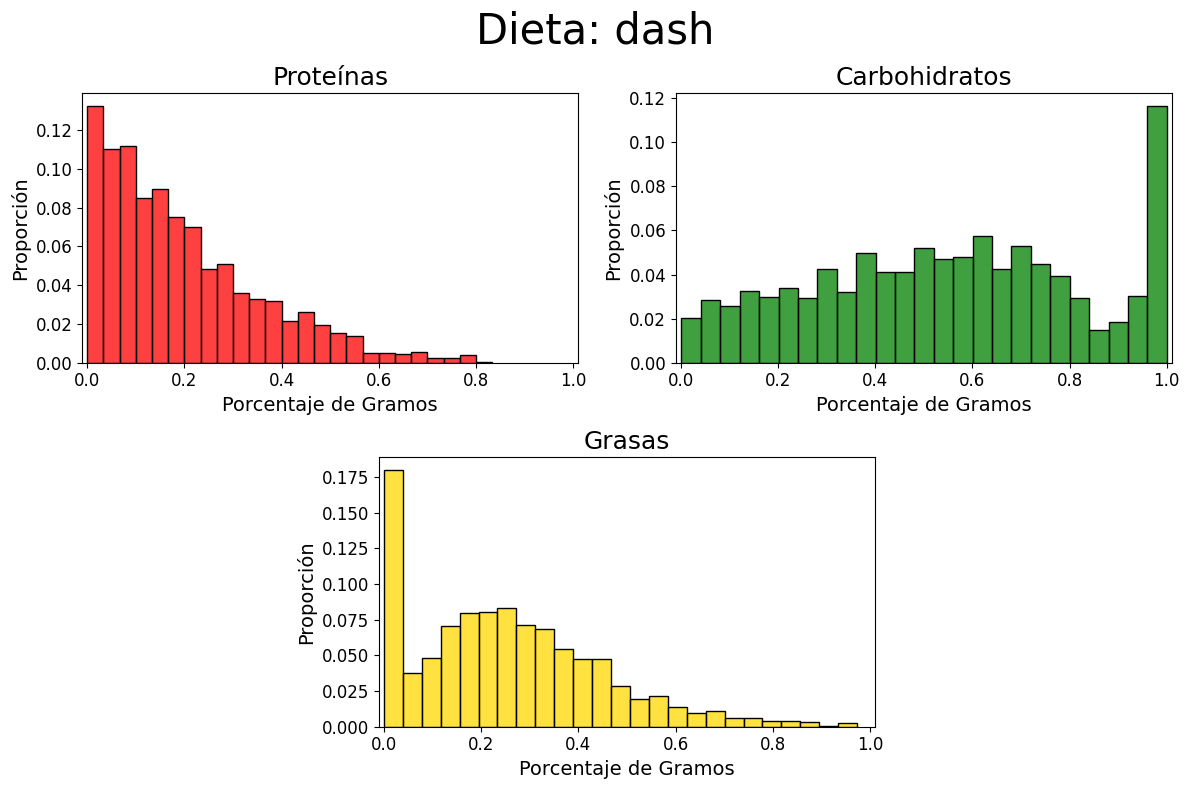

In [98]:
Plot_MacronutientsByDiet_Histogram(Diets_Dataset,diet)

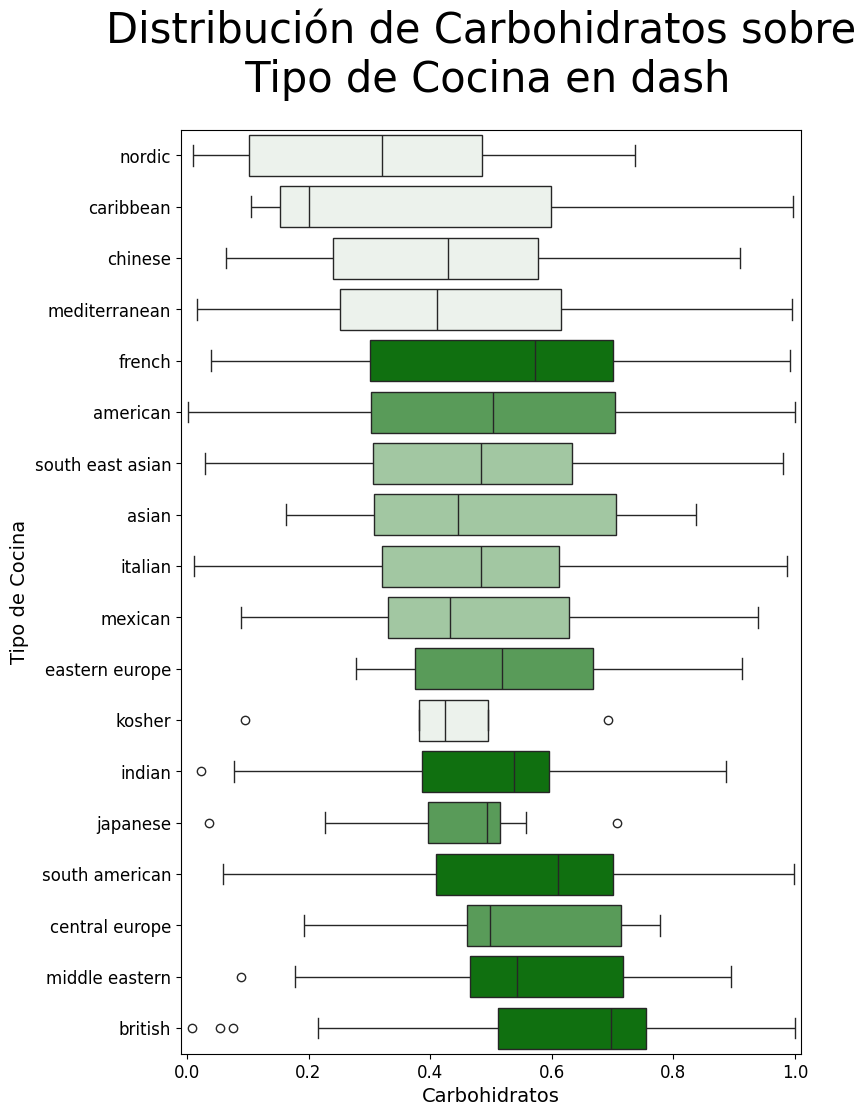

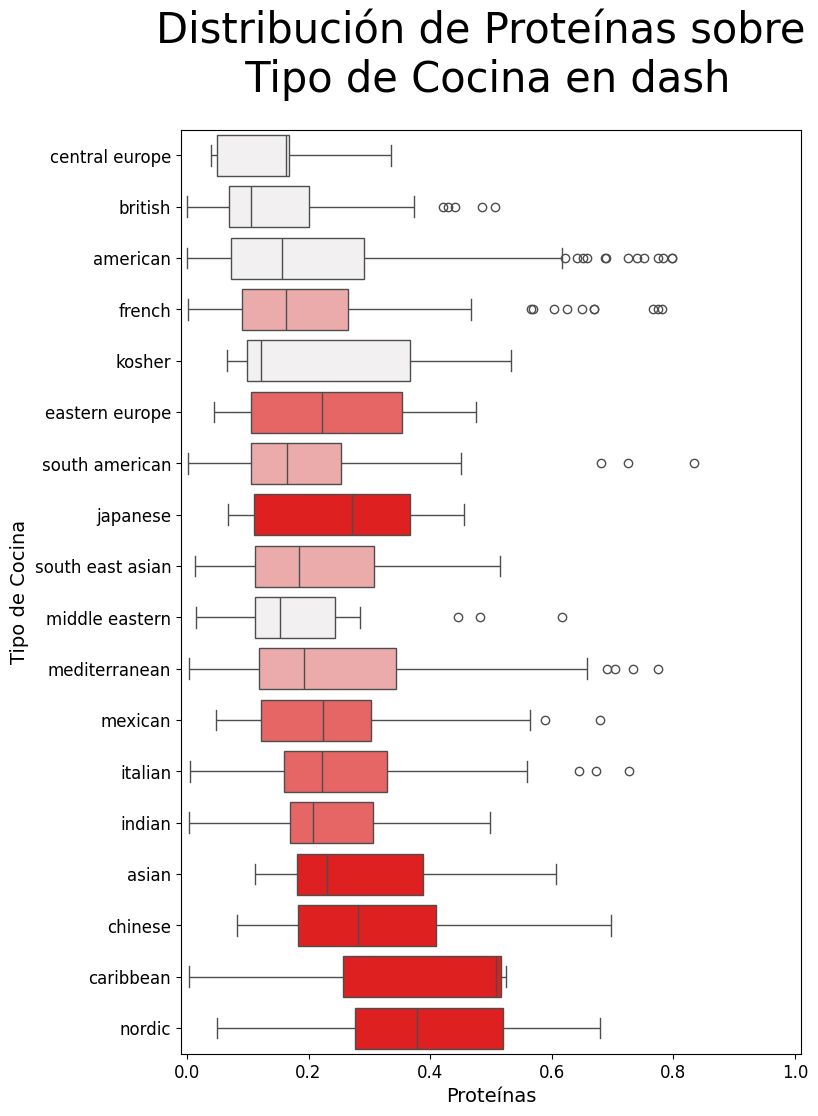

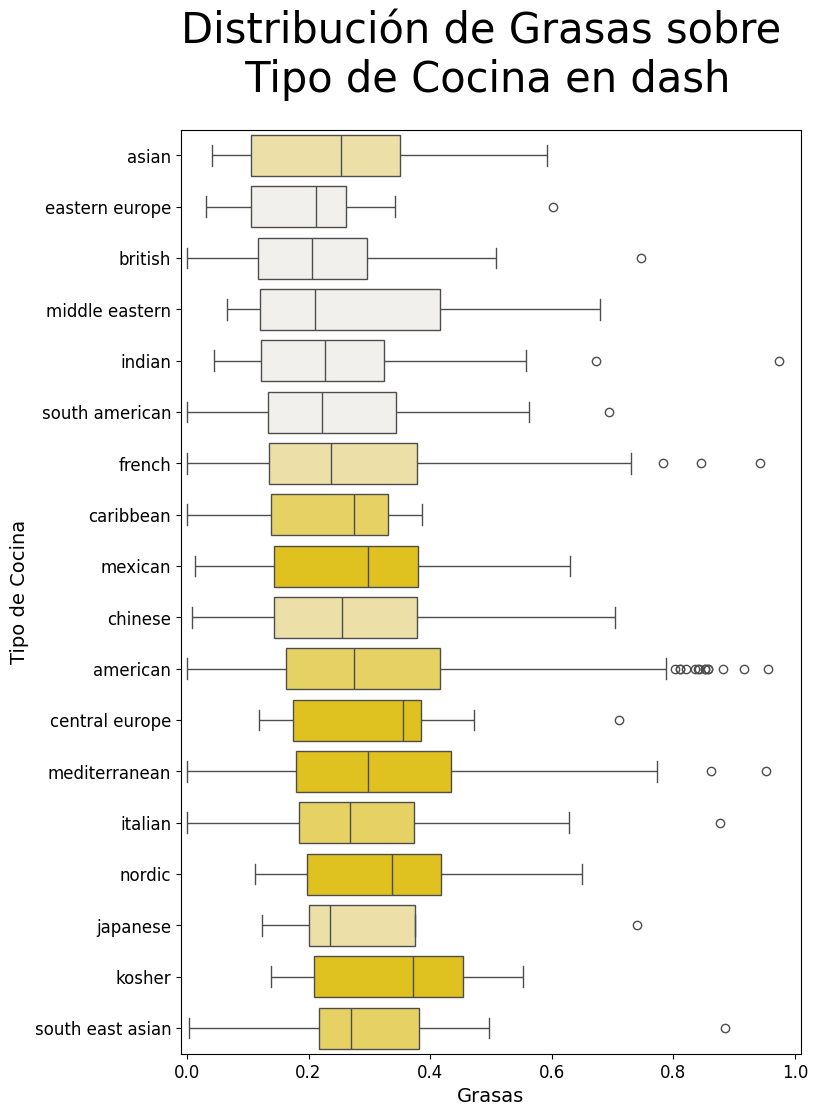

In [99]:
for macronutrient in Macronutrients:
    PlotMacronutrientsByCuisine(Diets_Dataset.query("Cuisine_type != 'world'"),diet,macronutrient)

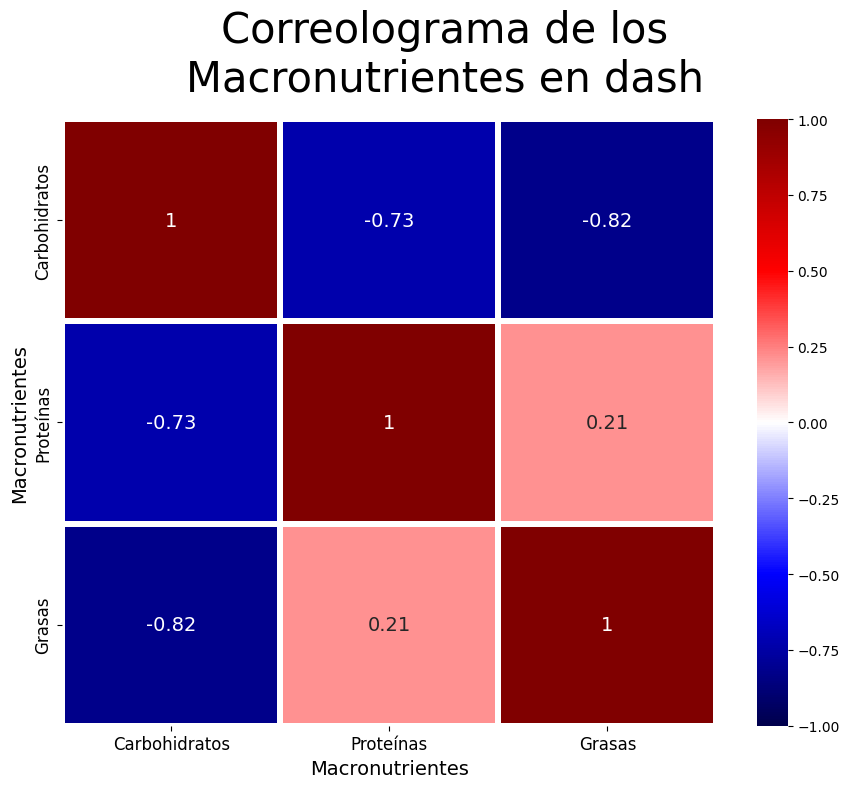

In [100]:
PlotMacronutrientsCorreologram(Diets_Dataset,diet)

### 5.4.2 Dieta Keto

In [101]:
diet = Diets[1]

print(f'Dieta: {diet}')
SummaryMeasures(Diets_Dataset.query("Diet_type == @diet"))

Dieta: keto


,Carbs,Protein,Fat
mean,0.200879,0.301777,0.497344
25%,0.085517,0.158284,0.405354
50%,0.157348,0.302900,0.505751
75%,0.267535,0.409453,0.591887
std,0.160609,0.167027,0.166572
min,0.002060,0.000000,0.000000
max,1.000000,0.856868,0.997940
skewness,1.634945,0.314795,-0.147406


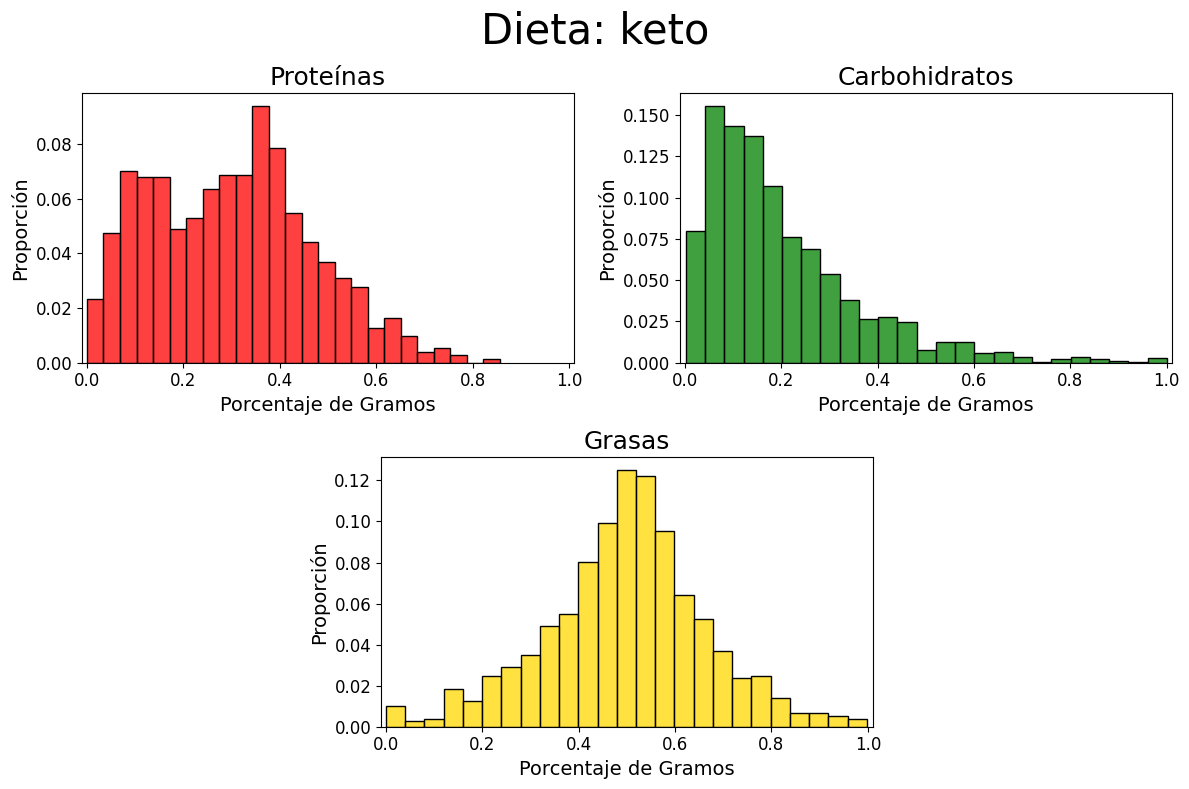

In [102]:
Plot_MacronutientsByDiet_Histogram(Diets_Dataset,diet)

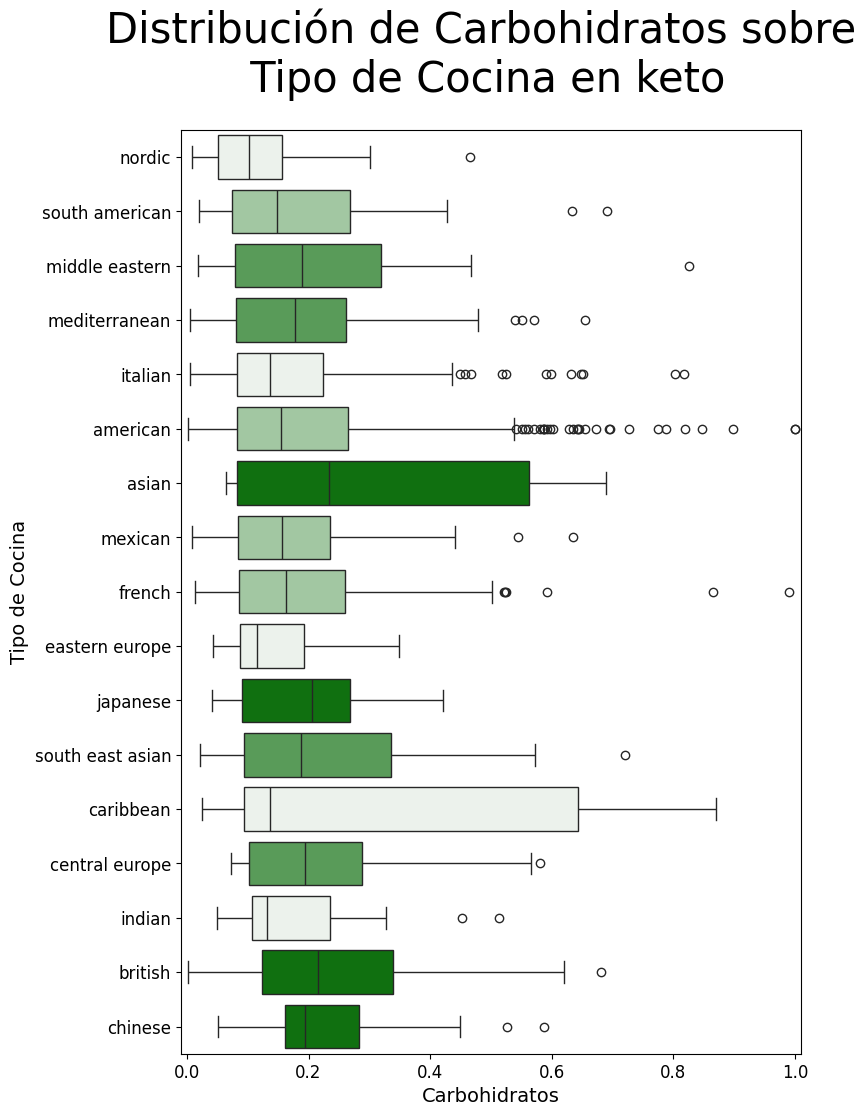

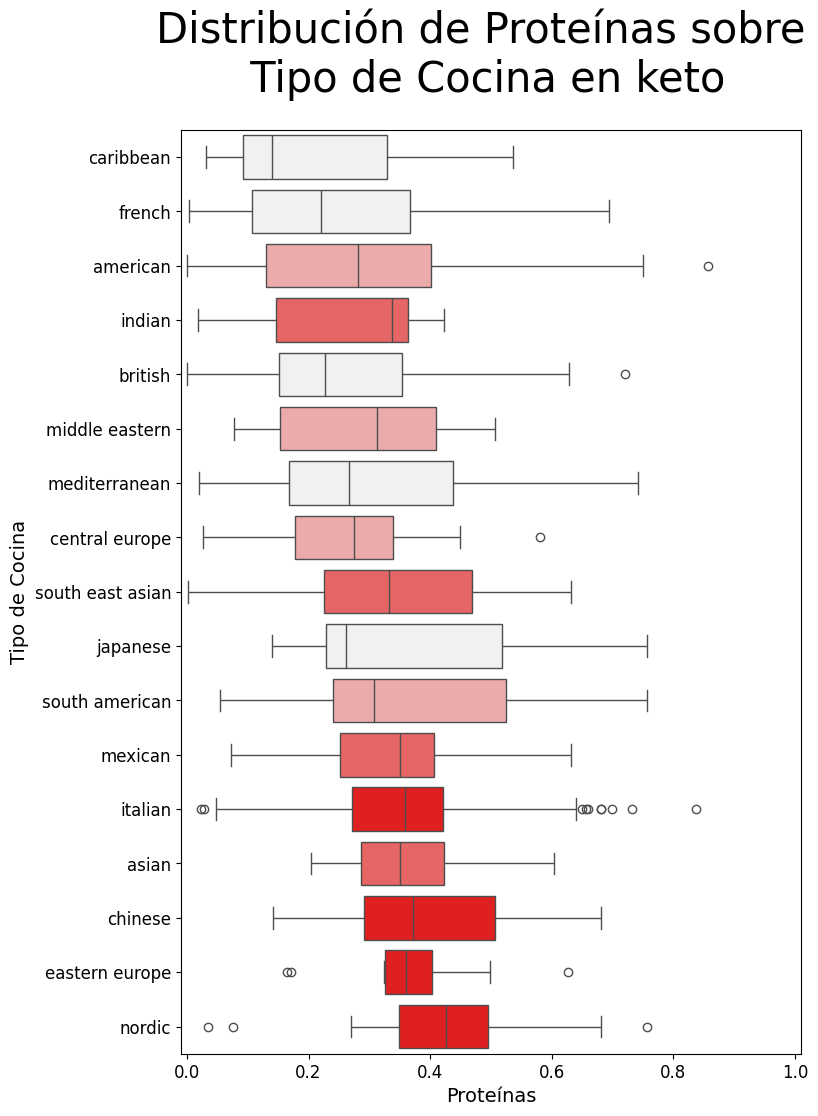

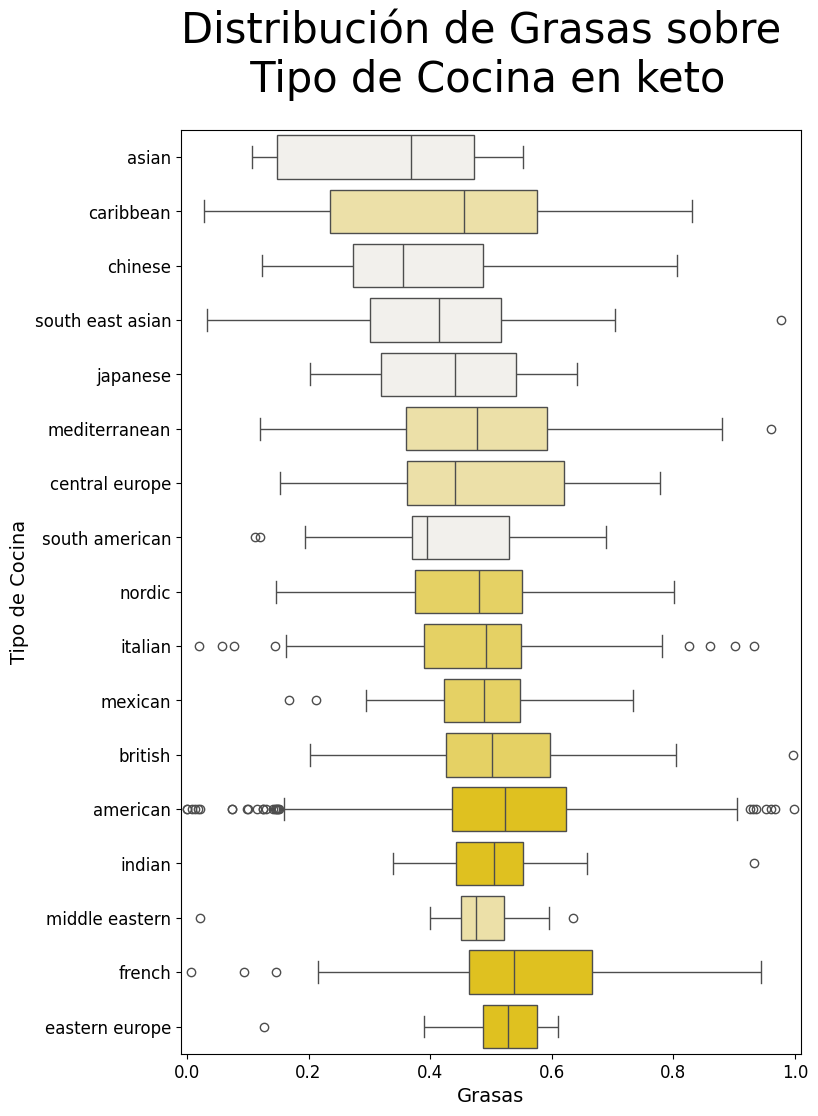

In [103]:
for macronutrient in Macronutrients:
    PlotMacronutrientsByCuisine(Diets_Dataset.query("Cuisine_type != 'world'"),diet,macronutrient)

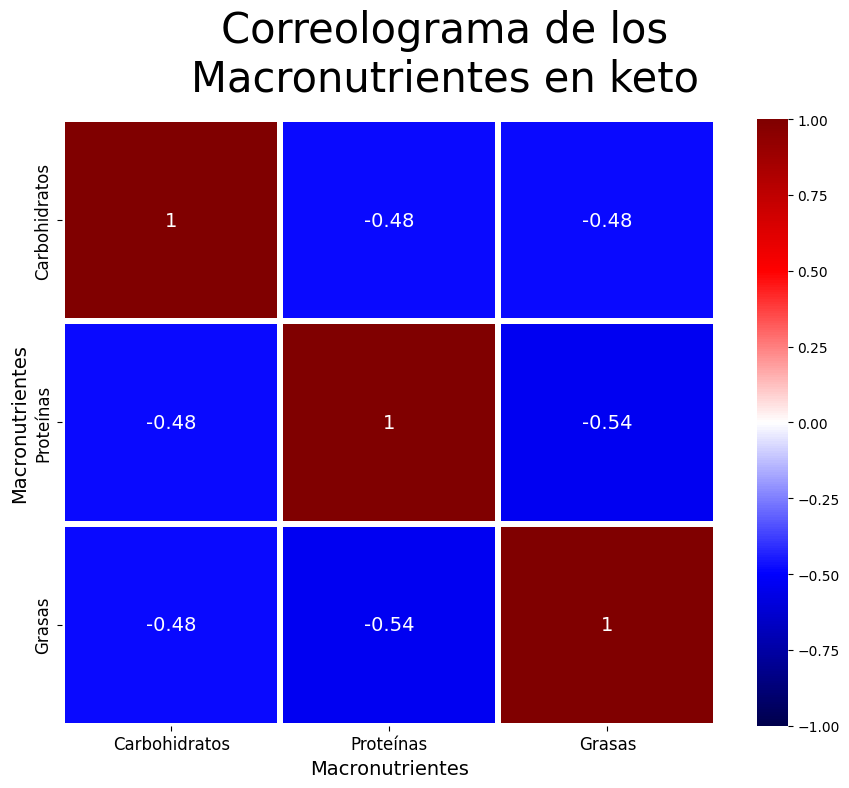

In [104]:
PlotMacronutrientsCorreologram(Diets_Dataset,diet)

### 5.4.3 Dieta Mediterráneo

In [105]:
diet = Diets[2]

print(f'Dieta: {diet}')
SummaryMeasures(Diets_Dataset.query("Diet_type == @diet"))

Dieta: mediterranean


,Carbs,Protein,Fat
mean,0.424493,0.279357,0.296150
25%,0.249955,0.159633,0.180357
50%,0.439382,0.227883,0.268336
75%,0.607531,0.377820,0.390404
std,0.214325,0.162853,0.160783
min,0.006733,0.005036,0.001731
max,0.992746,0.887557,0.968722
skewness,-0.096055,0.955922,0.869493


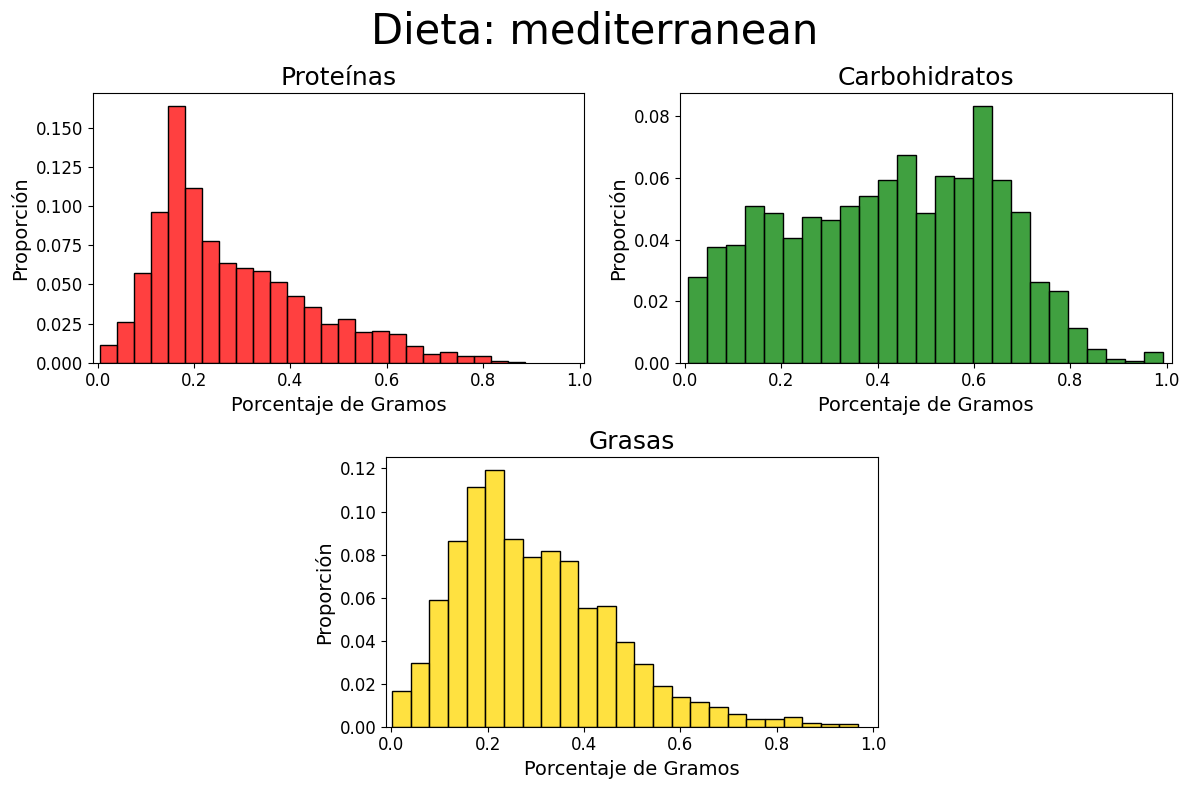

In [106]:
Plot_MacronutientsByDiet_Histogram(Diets_Dataset,diet)

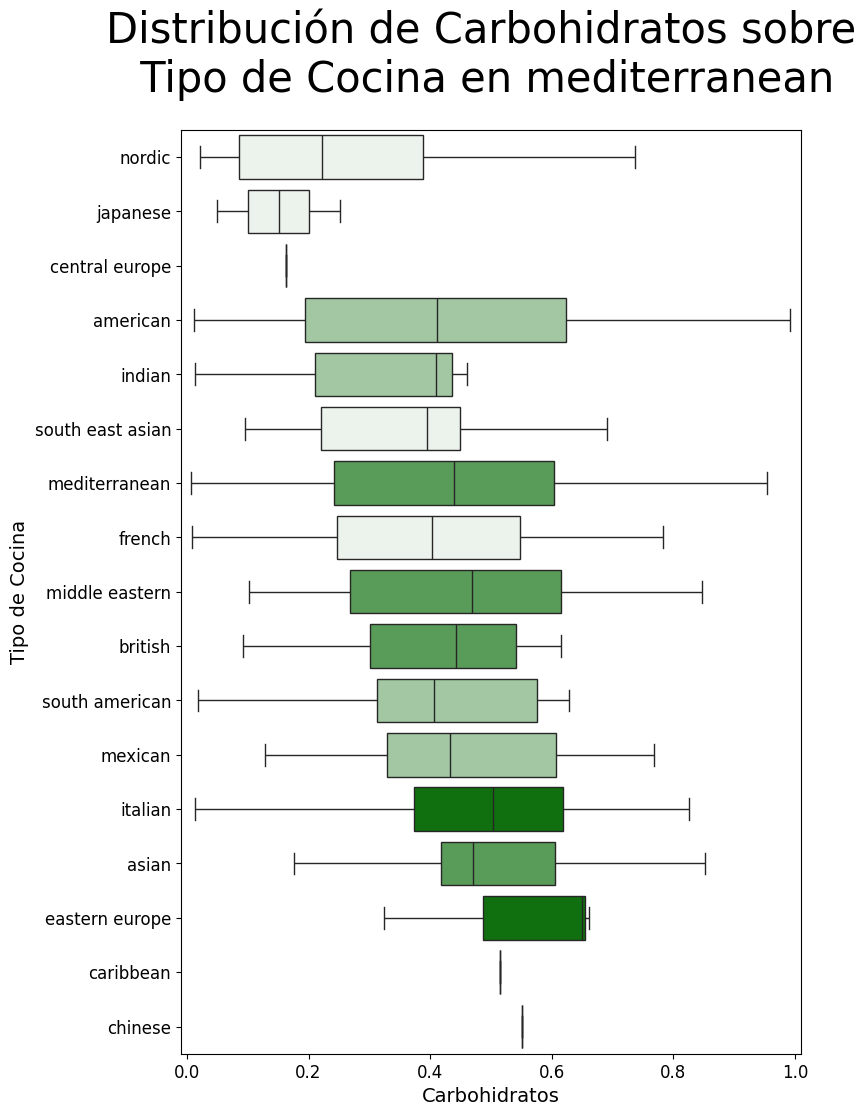

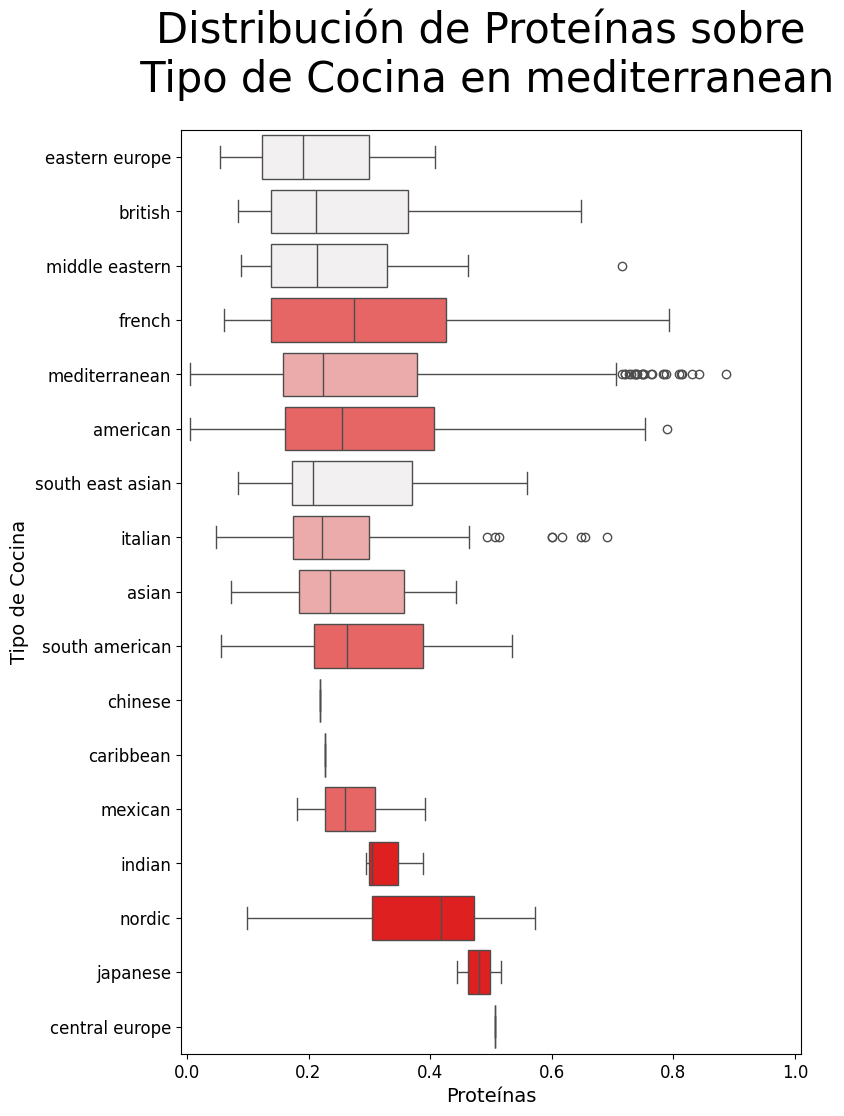

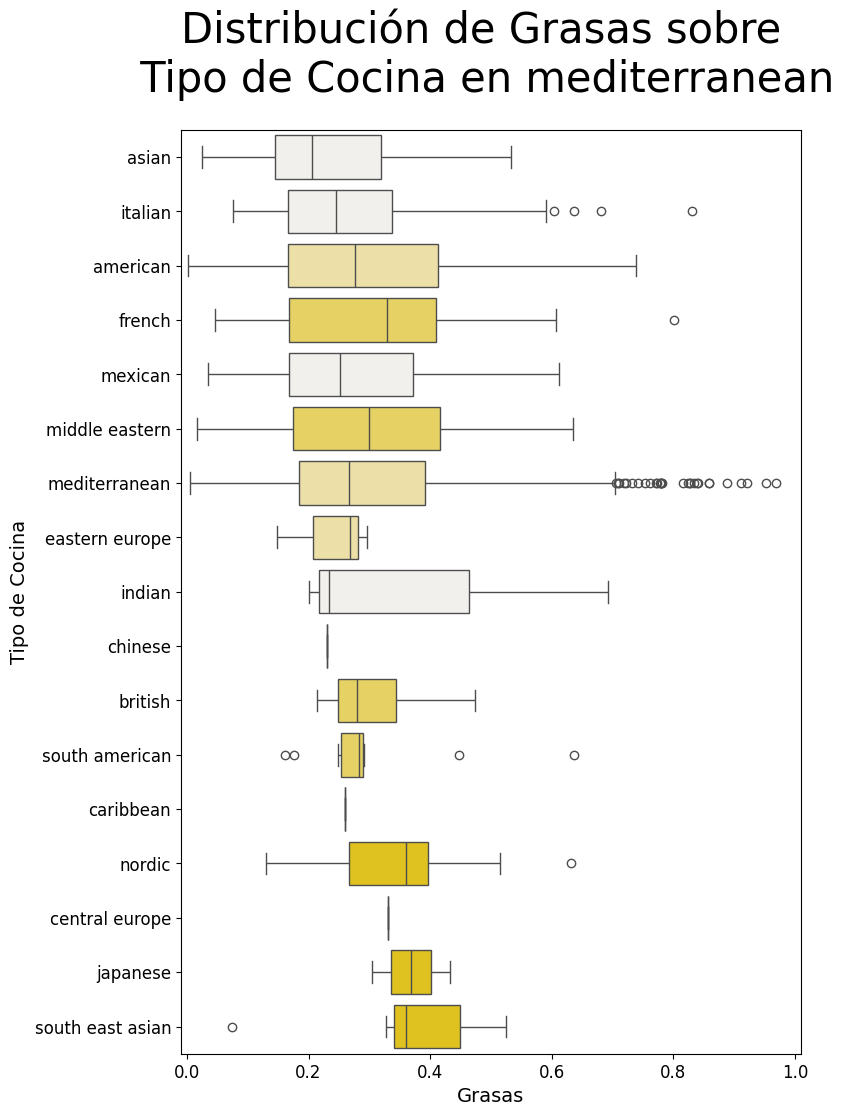

In [107]:
for macronutrient in Macronutrients:
    PlotMacronutrientsByCuisine(Diets_Dataset.query("Cuisine_type != 'world'"),diet,macronutrient)

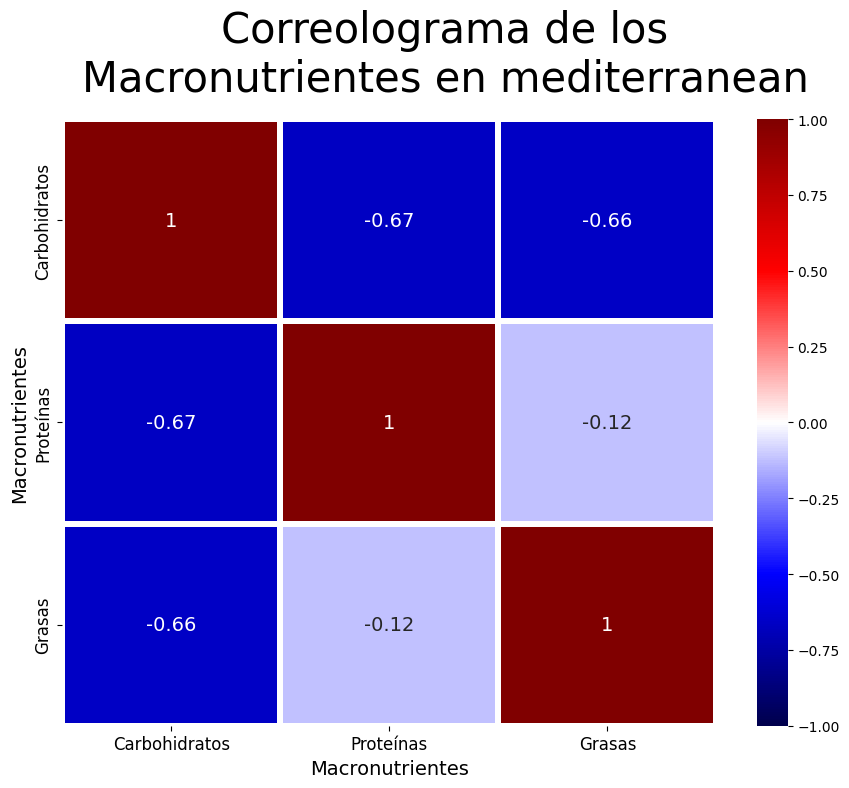

In [108]:
PlotMacronutrientsCorreologram(Diets_Dataset,diet)

### 5.4.4 Dieta Paleo

In [109]:
diet = Diets[3]

print(f'Dieta: {diet}')
SummaryMeasures(Diets_Dataset.query("Diet_type == @diet"))

Dieta: paleo


,Carbs,Protein,Fat
mean,0.371307,0.249693,0.379000
25%,0.192399,0.102963,0.256579
50%,0.351300,0.205532,0.382447
75%,0.515054,0.375392,0.488116
std,0.221506,0.175031,0.175471
min,0.003612,0.000000,0.001404
max,0.987368,0.858503,0.968835
skewness,0.488656,0.711408,0.312673


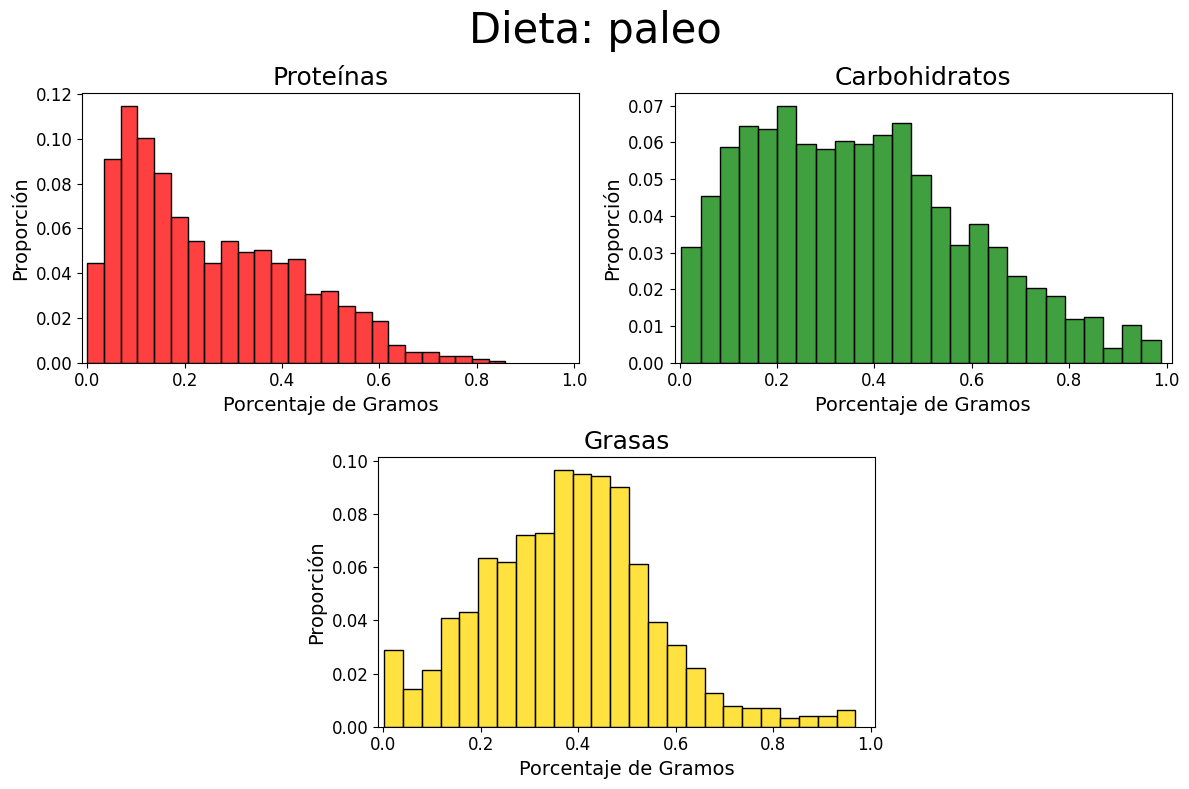

In [110]:
Plot_MacronutientsByDiet_Histogram(Diets_Dataset,diet)

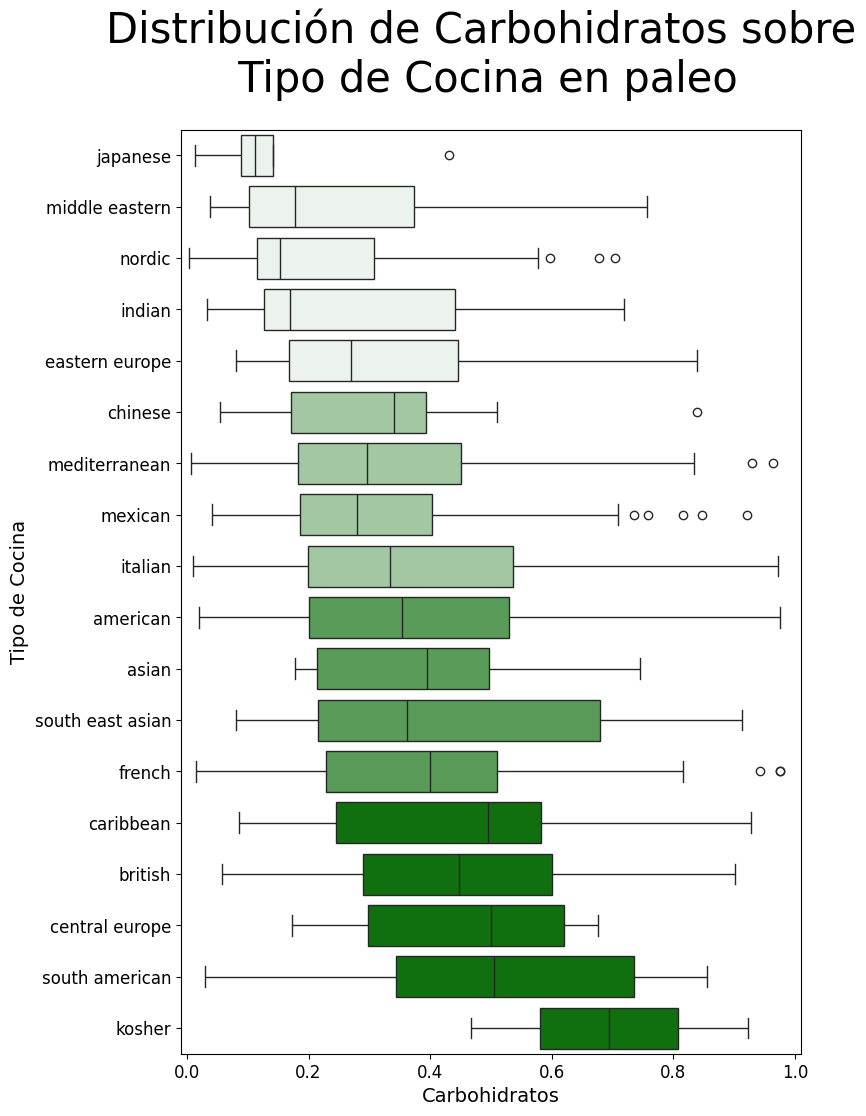

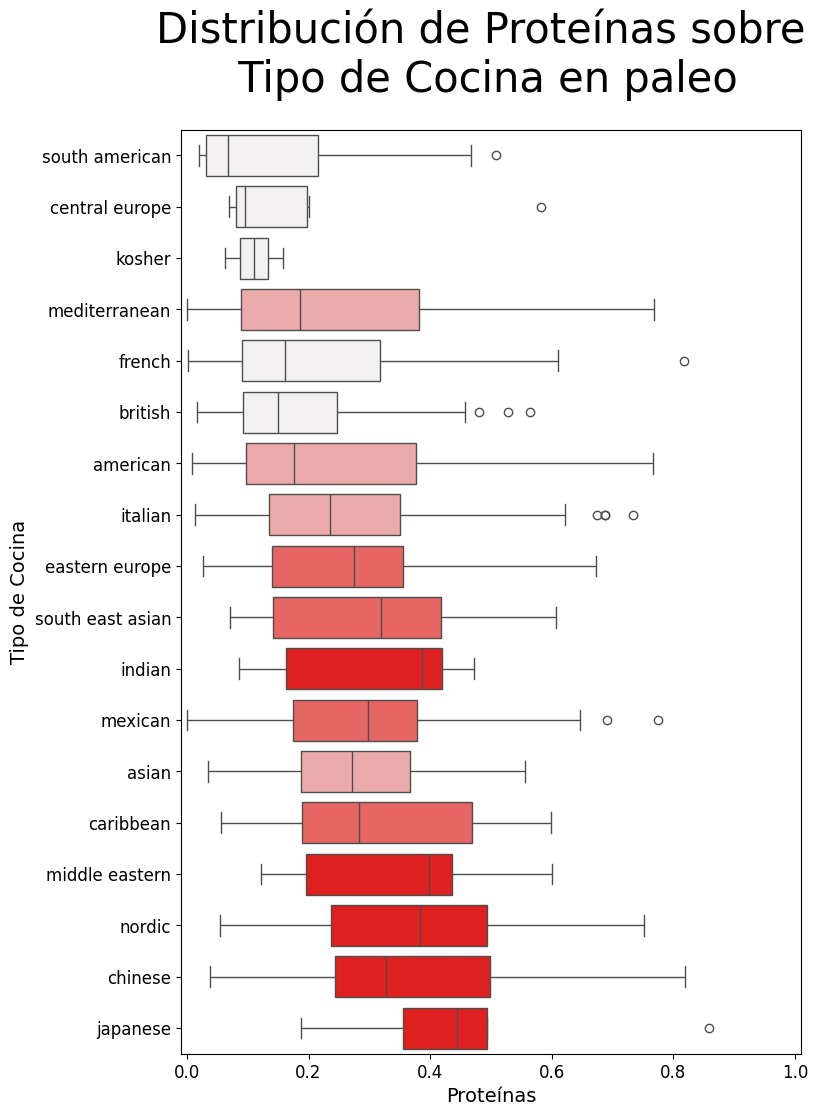

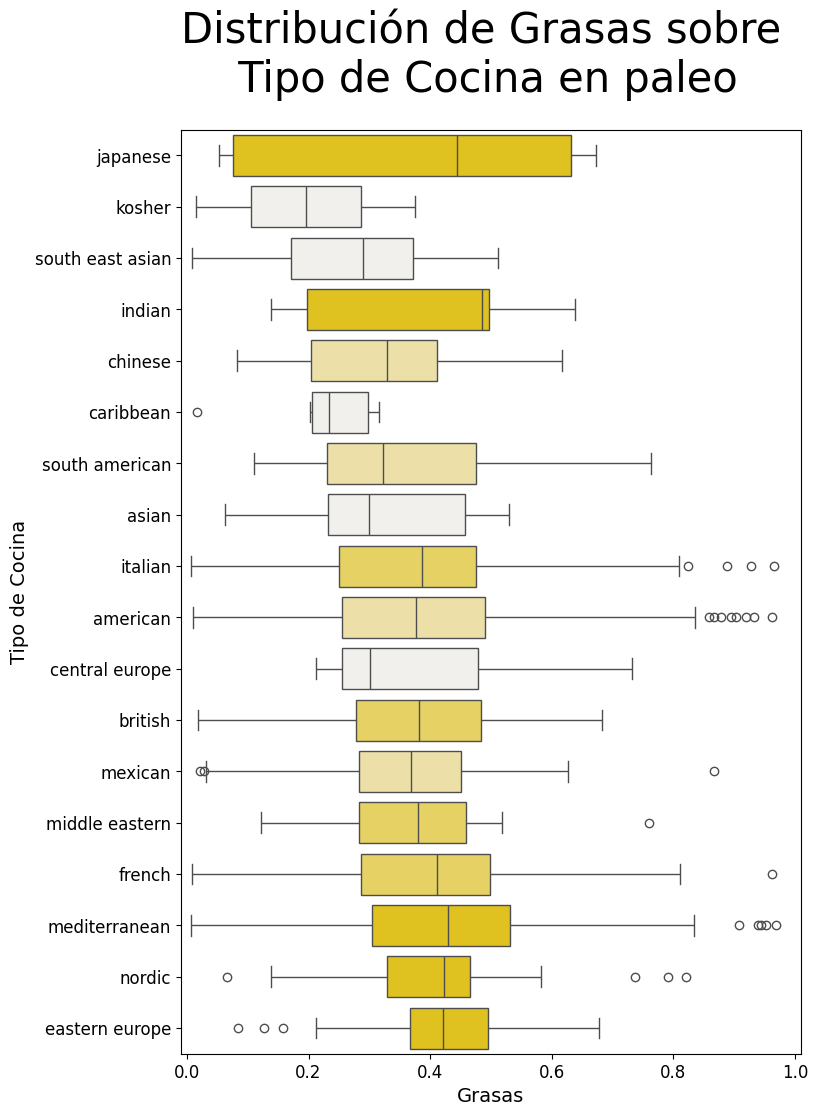

In [111]:
for macronutrient in Macronutrients:
    PlotMacronutrientsByCuisine(Diets_Dataset.query("Cuisine_type != 'world'"),diet,macronutrient)

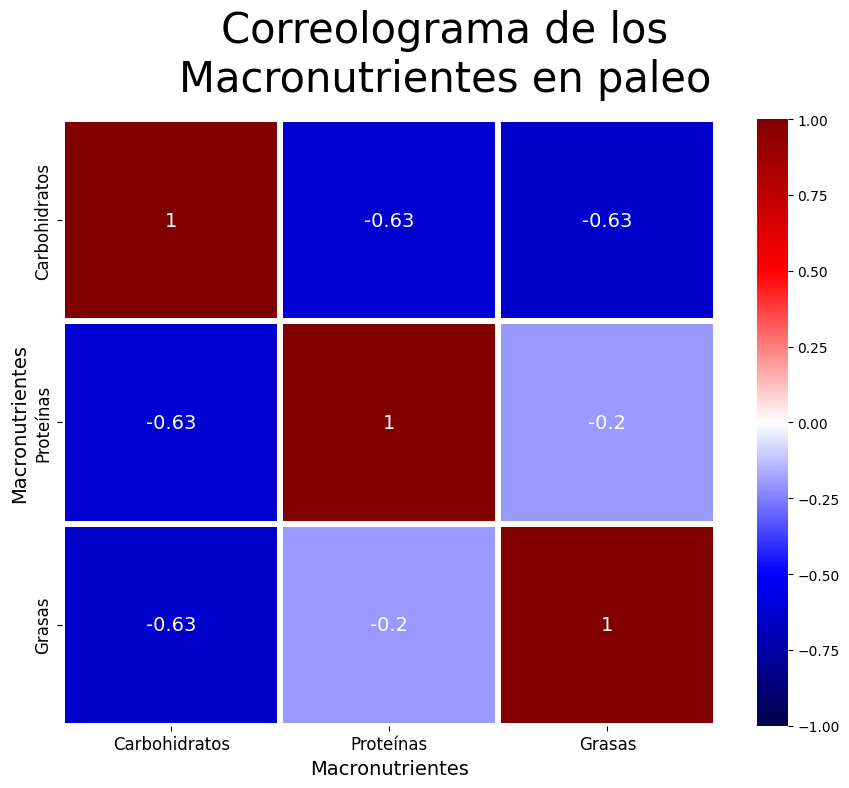

In [112]:
PlotMacronutrientsCorreologram(Diets_Dataset,diet)

### 5.4.5 Dieta Vegana

In [113]:
diet = Diets[4]

print(f'Dieta: {diet}')
SummaryMeasures(Diets_Dataset.query("Diet_type == @diet"))

Dieta: vegan


,Carbs,Protein,Fat
mean,0.593968,0.148489,0.257543
25%,0.504070,0.085339,0.142575
50%,0.626246,0.139688,0.231518
75%,0.714679,0.190381,0.344529
std,0.171203,0.086088,0.160277
min,0.000330,0.001921,0.000112
max,0.986872,0.647416,0.994887
skewness,-0.735651,1.439081,1.091809


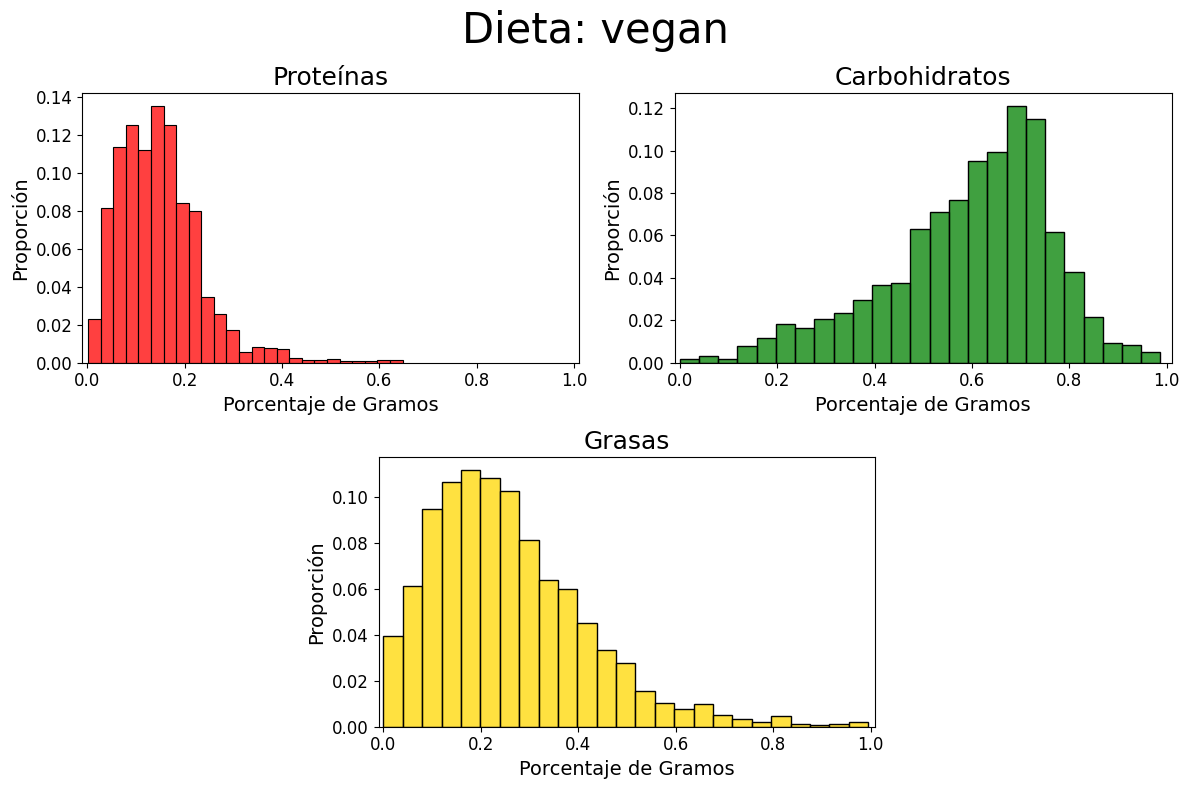

In [114]:
Plot_MacronutientsByDiet_Histogram(Diets_Dataset,diet)

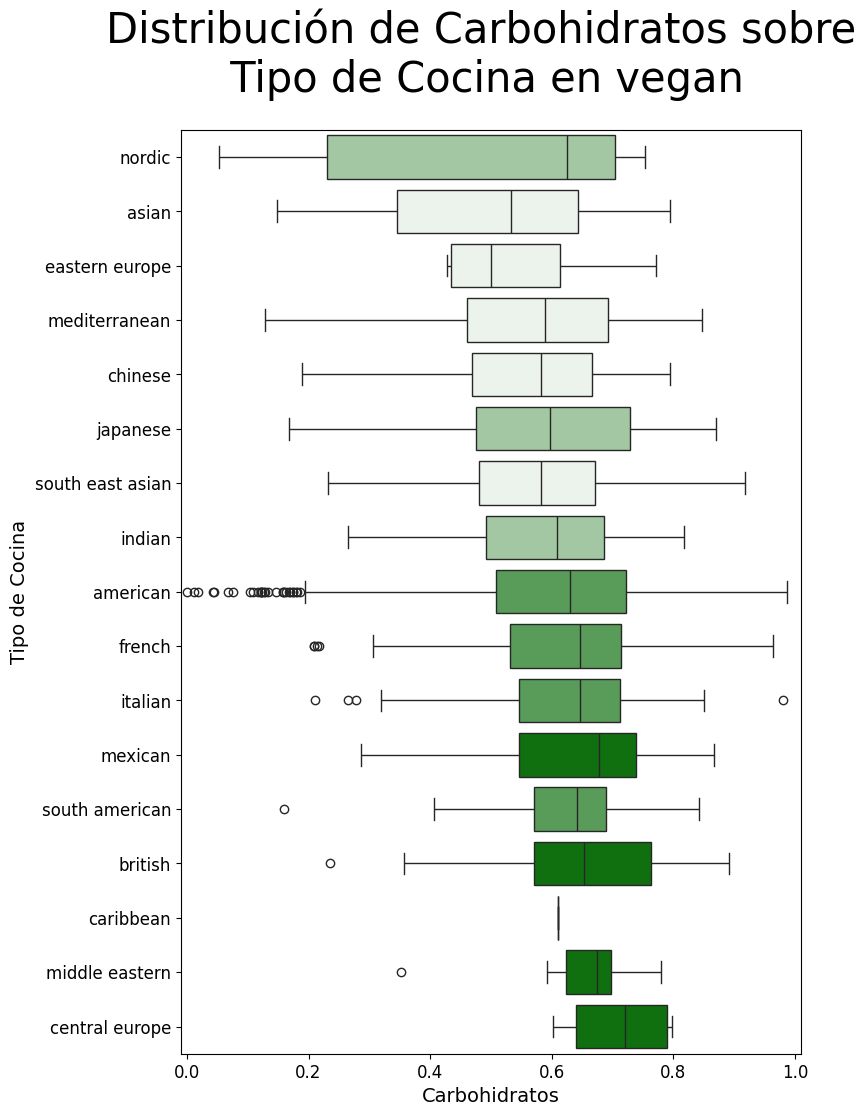

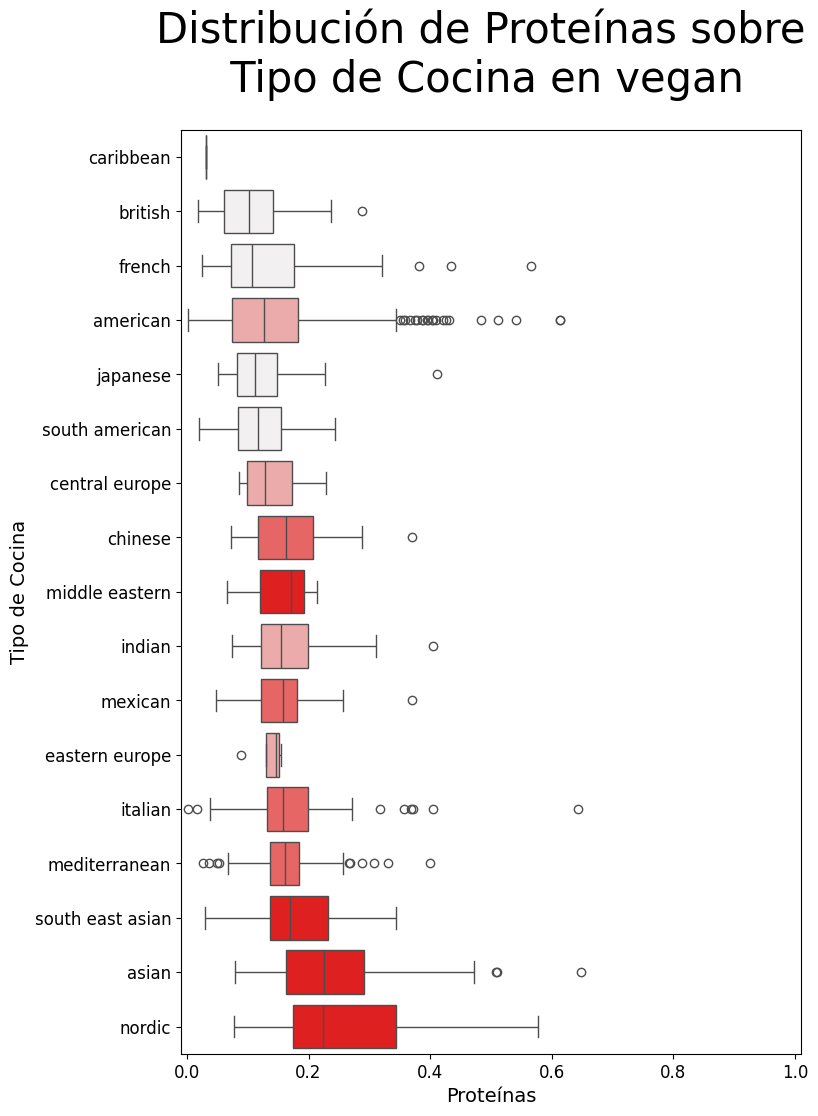

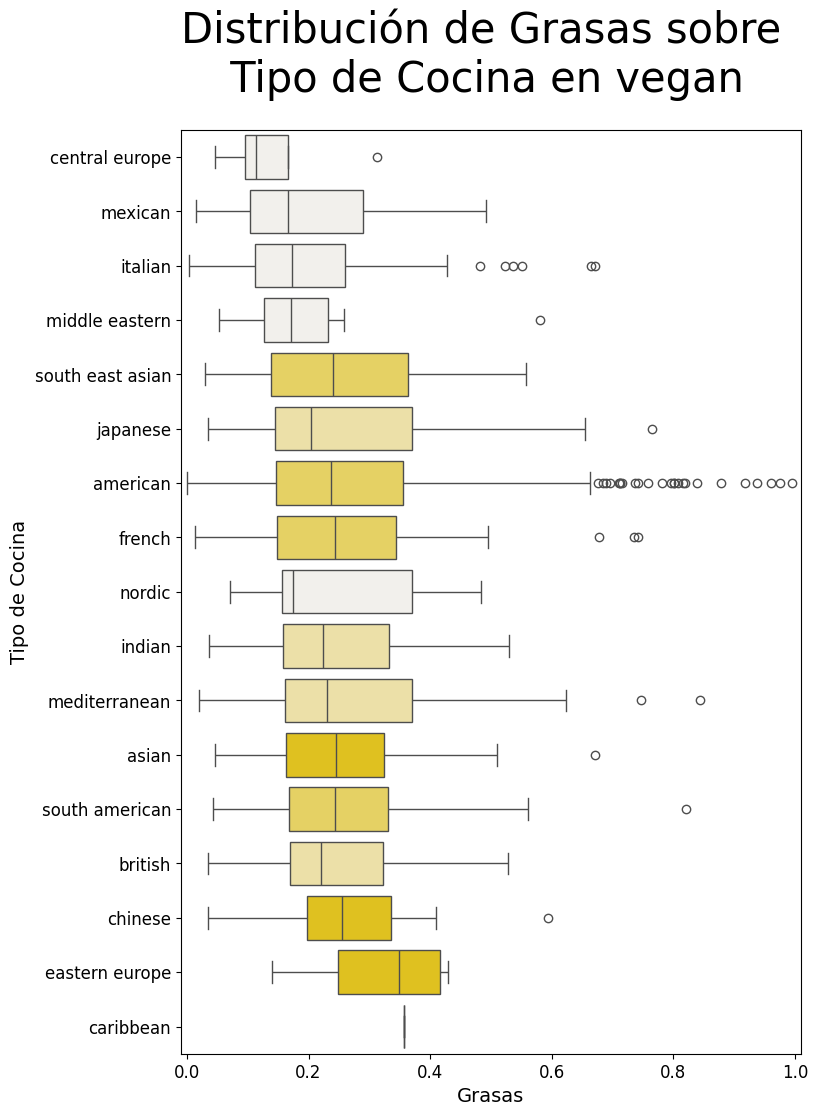

In [115]:
for macronutrient in Macronutrients:
    PlotMacronutrientsByCuisine(Diets_Dataset.query("Cuisine_type != 'world'"),diet,macronutrient)

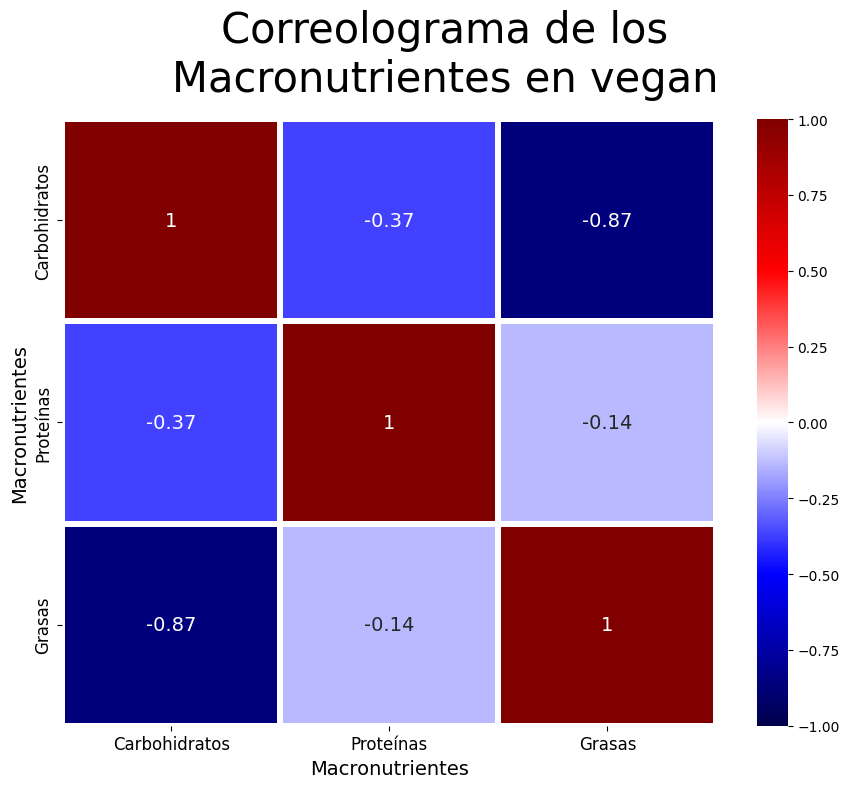

In [116]:
PlotMacronutrientsCorreologram(Diets_Dataset,diet)

### 5.4.6 Boxplot de Macronutrientes por Dieta

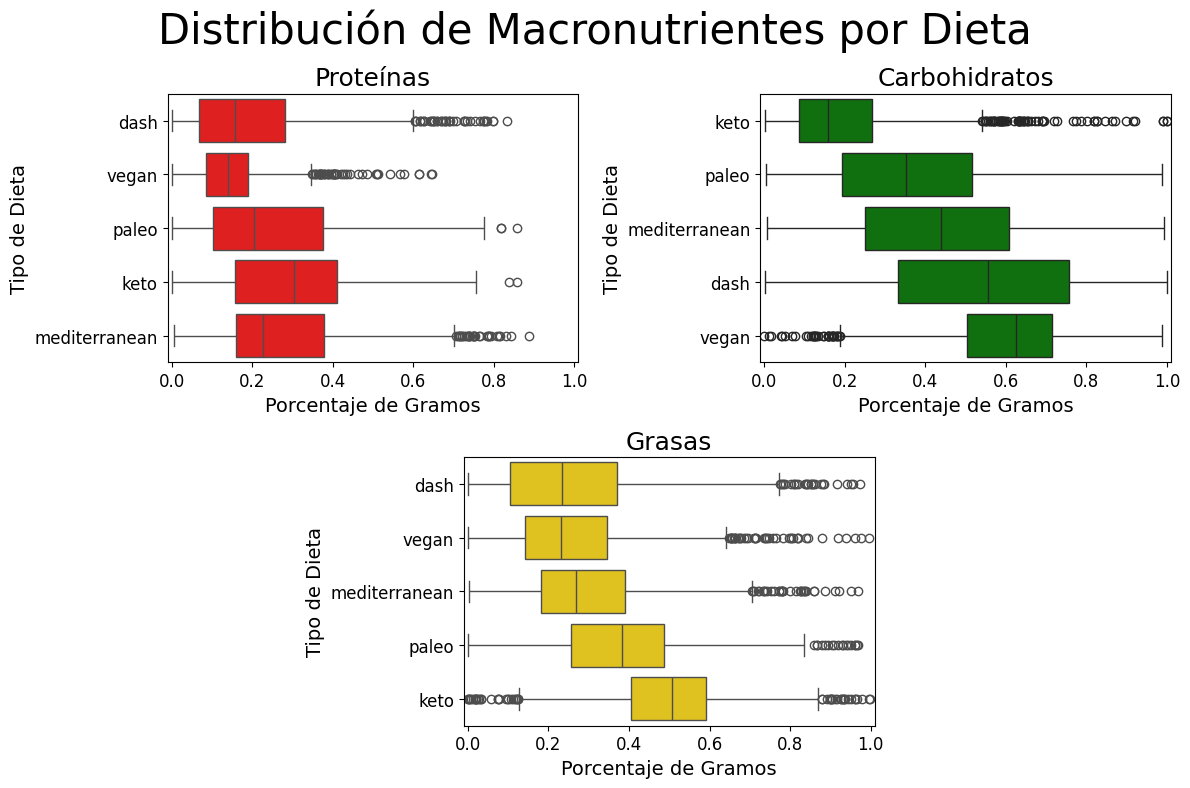

In [117]:
# Boxplot de los macronutrientes por dieta

Plot_MacronutrientsByDiet_Boxplot(Diets_Dataset)

## 5.5 Caracterización de las Distribuciones de los Macronutrientes

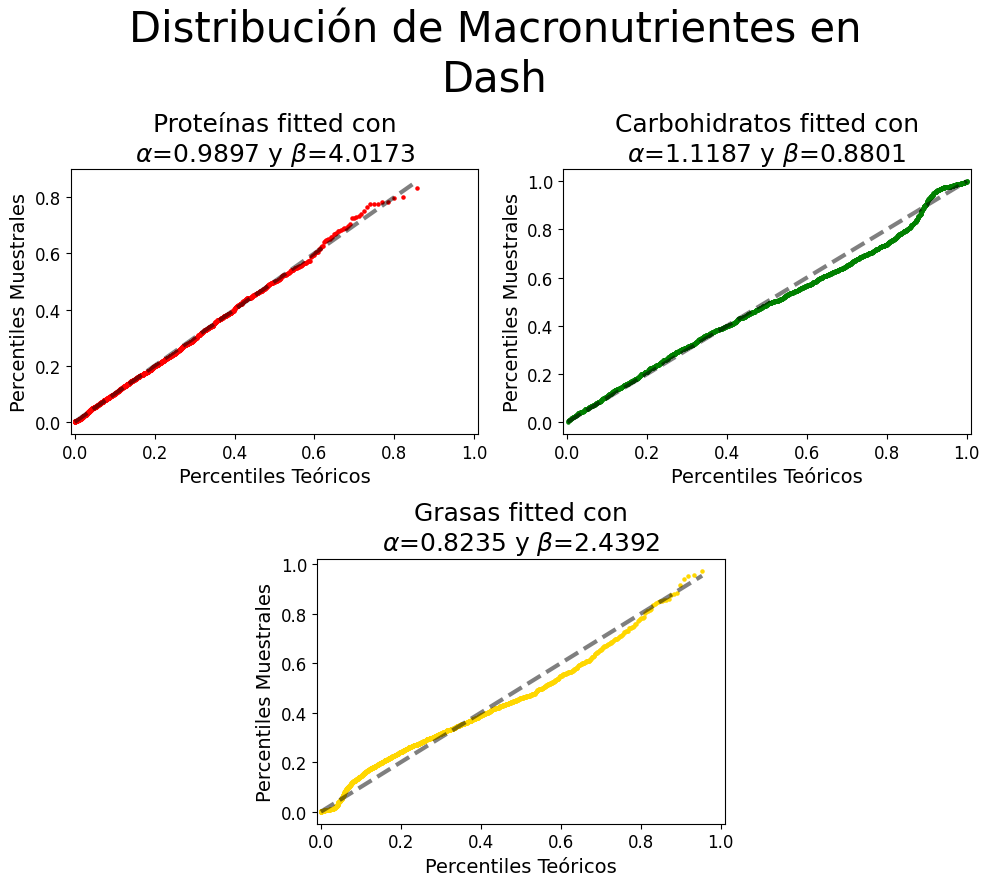

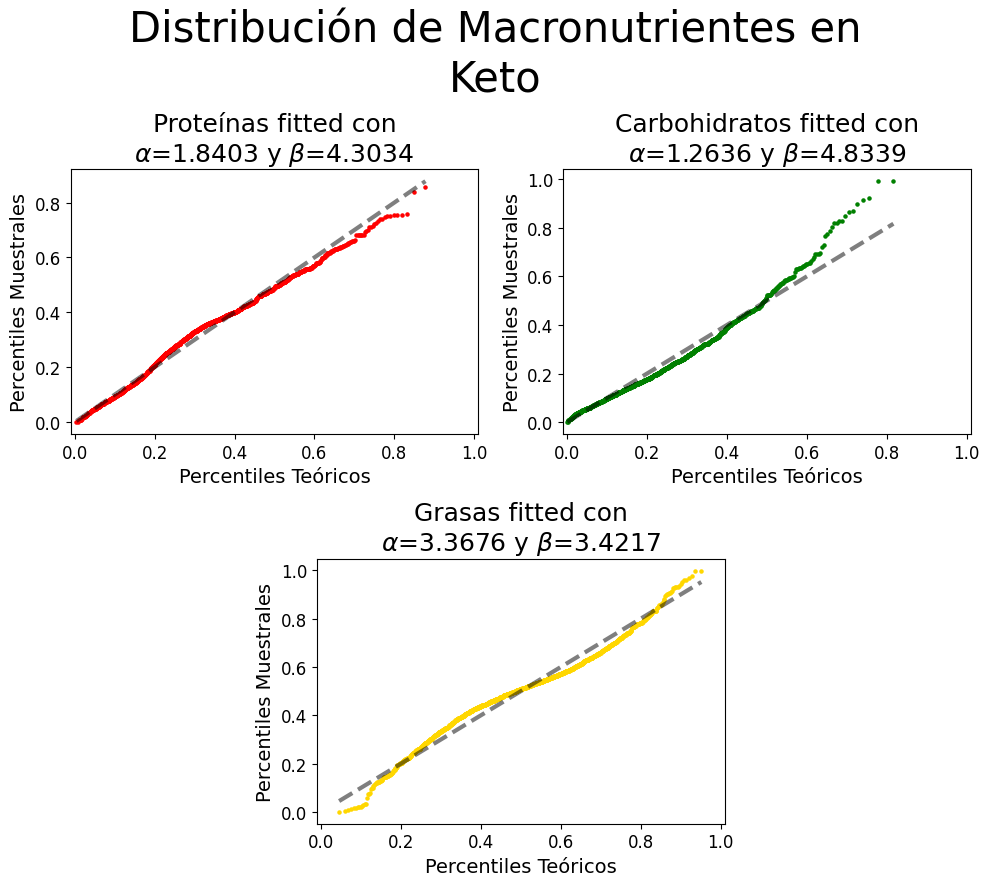

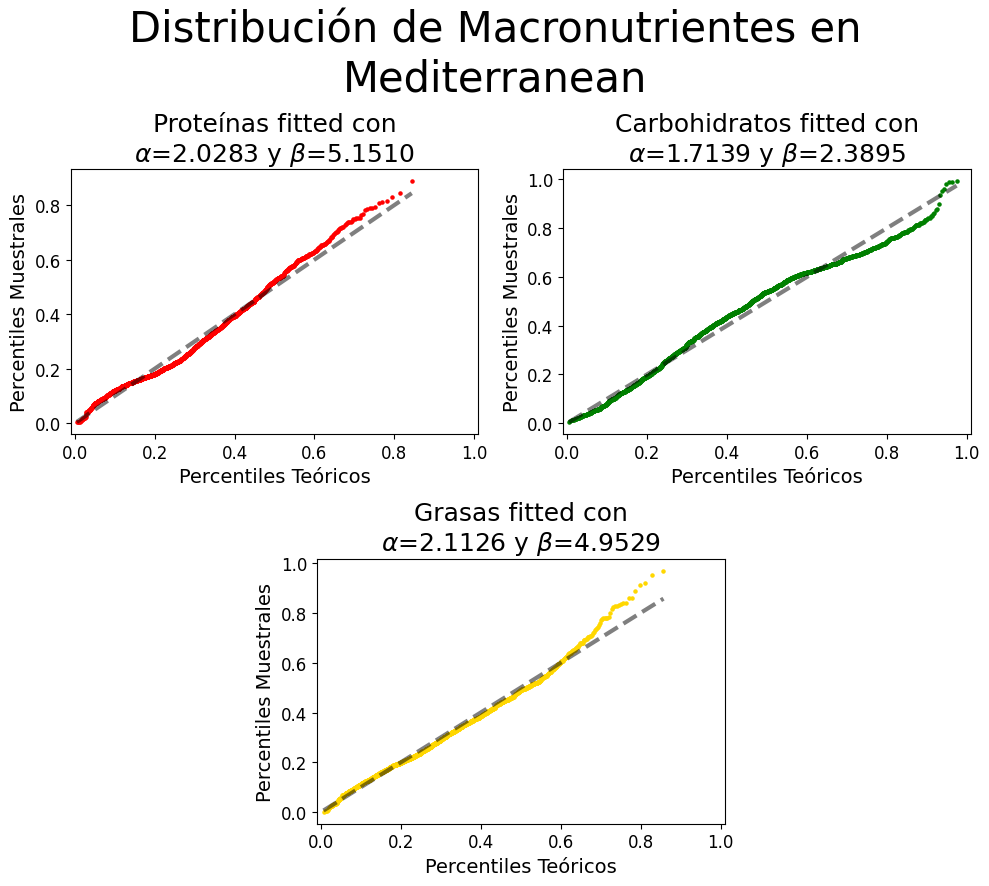

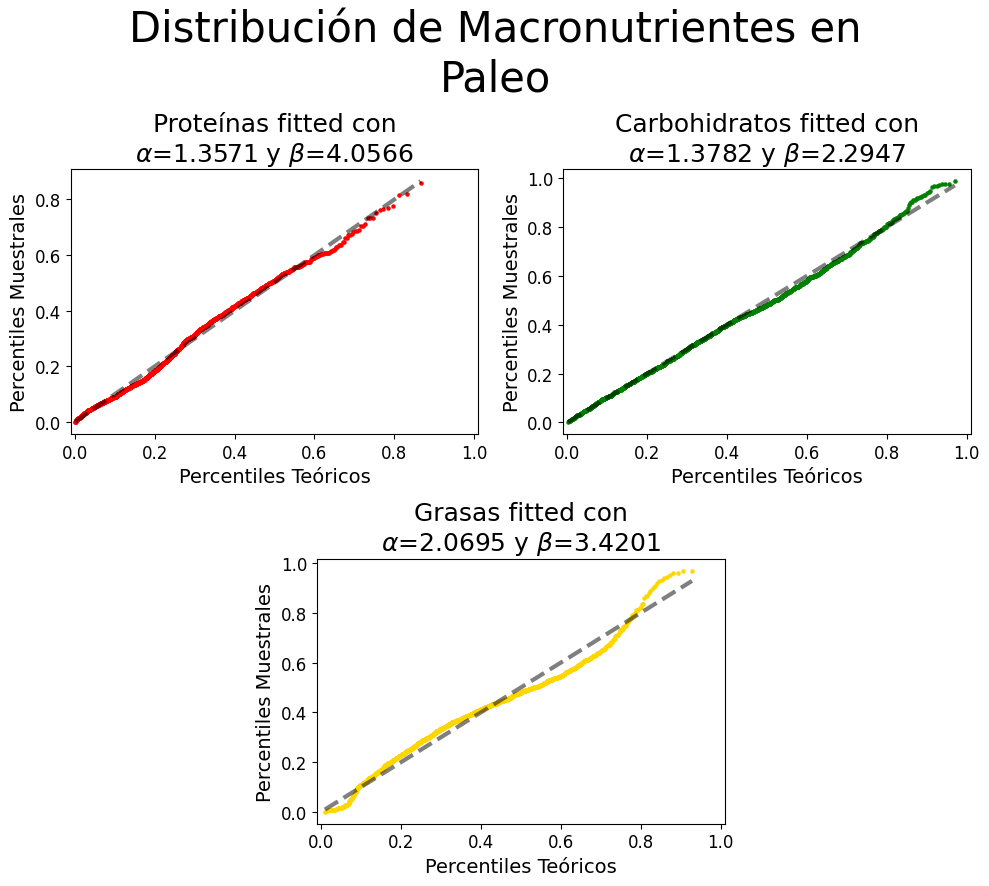

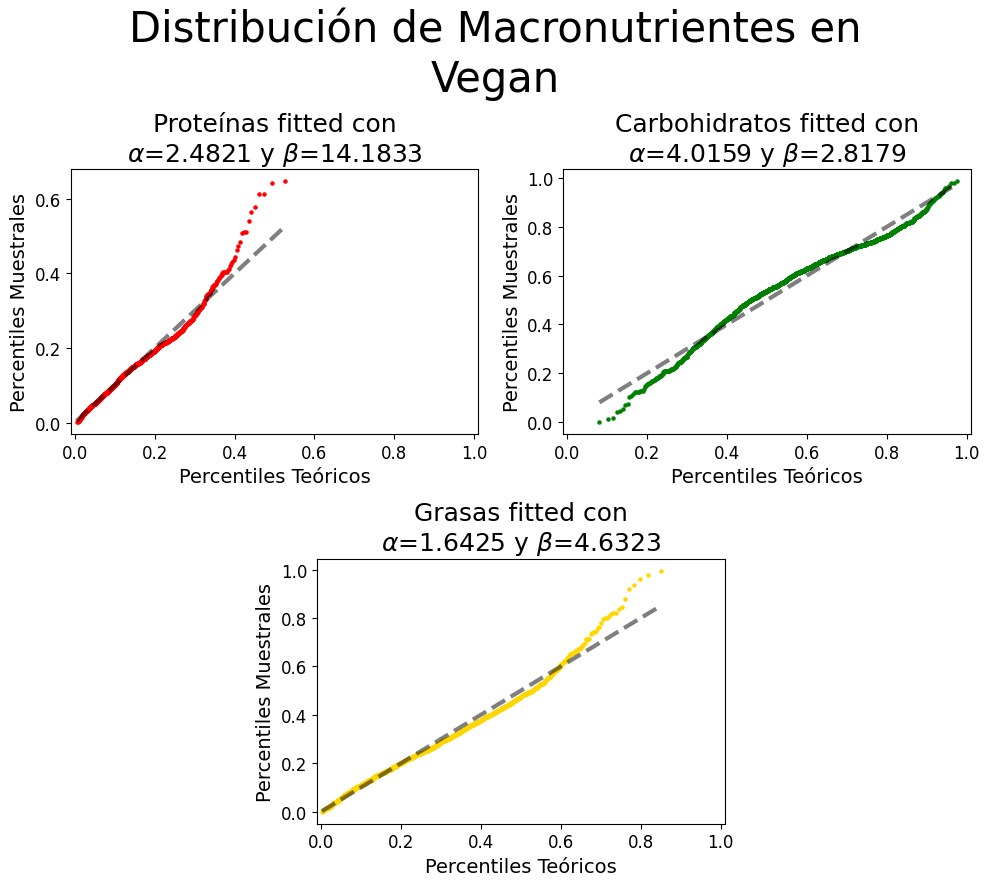

In [118]:
# Plot de los Q-Q Plots de los macronutrientes por dieta

for diet in Diets:
    PlotQQByDiet(Diets_Dataset,diet)

# 6. Prueba de Hipótesis por Dieta

## 6.1 Prueba para Dieta DASH

Suponiendo que la cantidad diaria de comidas que se consumen son cinco. Se tiene que para probar que la dieta DASH está balanceada basta con muestrear 50 días consumiendo recetas de esta dieta, es decir, muestrear 250 recetas de forma aleatoria y agruparlas en cinco en cinco recetas, y obtener la proporción de macronutrientes que aportan.

El juego de hipótesis es: 
$$ H_0 : \overline{x}_M = \frac{1}{3}$$
$$ H_1 : \overline{x}_M \ne \frac{1}{3}$$

Se usa la Prueba t para obtener resultados significativos con dos colas.

Debido a que los p valores son menores a la significancia de $0.05$ se tiene que para los tres macronutrientes se descarta la hipótesis de que los macronutrientes estén balanceados

In [119]:
from scipy.stats import ttest_1samp

In [120]:
# Muestreo de recetas

recipes_sample_dash = Diets_Dataset.query("Diet_type == 'dash'").sample(250,random_state=RANDOM_STATE,ignore_index=True)[Macronutrients+[Total]]

# Obtención de macronutrientes en cada receta

recipes_sample_dash[Macronutrients] *= recipes_sample_dash[Total].to_numpy()[:,None]

recipes_sample_dash

,Carbs,Protein,Fat,Total_Macronutrients
0,9.66,0.12,0.02,9.80
1,47.08,29.53,23.40,100.01
2,68.10,14.17,88.94,171.21
3,3.59,0.23,0.07,3.89
4,422.23,105.45,98.80,626.48
...,...,...,...,...
245,41.48,38.03,24.15,103.66
246,1019.34,61.21,105.84,1186.39
247,49.96,65.41,16.52,131.89
248,155.78,13.99,36.19,205.96


In [121]:
# Agrupar recetas cinco en cinco

daily_macronutrients_dash = recipes_sample_dash.groupby(np.arange(250)//5).sum()

# Obtención de la proporción de macronutrientes

daily_macronutrients_dash[Macronutrients] /= daily_macronutrients_dash[Total].to_numpy()[:,None]

daily_macronutrients_dash.head(5)

,Carbs,Protein,Fat,Total_Macronutrients
0,0.604198,0.164035,0.231767,911.39
1,0.488966,0.121507,0.389527,1239.35
2,0.382710,0.289875,0.327415,2221.92
3,0.326052,0.384996,0.288952,1063.88
4,0.668720,0.103841,0.227439,391.27


In [122]:
# Aplicando la prueba t para cada macronutriente

for macronutrient in Macronutrients:
    test_result = ttest_1samp(daily_macronutrients_dash[macronutrient],1/3,alternative='two-sided')
    print(f"Para {MapTranslate[macronutrient]} se tiene ::")
    print(f'El estadístico de la prueba es {test_result.statistic} y su p valor se {test_result.pvalue}\n')

Para Carbohidratos se tiene ::
El estadístico de la prueba es 9.260587121292492 y su p valor se 2.4193804910147038e-12

Para Proteínas se tiene ::
El estadístico de la prueba es -10.42196340574205 y su p valor se 5.014442100891813e-14

Para Grasas se tiene ::
El estadístico de la prueba es -3.038974548508989 y su p valor se 0.0038014456458887276



## 6.2 Prueba para Dieta Keto 

Para cada cocina se quiere probar que las medias o medianas muestrales de los carbohidratos de las recetas sean menores que las de grasas. Se tiene el siguiente juego de hipótesis:
$$H_0 : \overline{c}_C = \overline{f}_C$$
$$H_1 : \overline{c}_C < \overline{f}_C$$

Para probar esto se tiene que considerar dos casos según la cantidad de muestras que cuenta cada recete se le aplica la Prueba t según la homocedasticidad de los datos si cuenta con más o iguales que $30$ recetas, en caso contrario se usa la Prueba de Rangos de Wilcoxon. Para ambas pruebas se usa una prueba de una cola izquierda

Para probar la homocedasticidad de se hace uso de la Prueba Levenne

Las cocinas en donde se verifica significativamente que las cocinas asiática , caribeña y global se cumple que los carbohidratos son menores que las grasas. Pero por usarse una prueba de Rangos de Wilcoxon implica que los resultados no se vuelve relevantes para estas cocinas, por lo tanto ninguna cocina verifica que la regla general de la dieta keto.

In [123]:
from scipy.stats import  ranksums , levene , ttest_ind 

In [124]:
# Obtener recetas de las dieta keto

recipes_cuisine_keto = Diets_Dataset.query("Diet_type == 'keto'").groupby(Cuisine)

In [125]:
# Prueba de hipótesis para cada cocina

for cuisine in recipes_cuisine_keto.groups.keys():
    recipes_by_cuisine = recipes_cuisine_keto.get_group(cuisine)
    num_recipes = recipes_by_cuisine.shape[0]
    
    if num_recipes < 30:
        test = 'Rangos de Wilcoxon'
        test_result = ranksums(recipes_by_cuisine['Carbs'],recipes_by_cuisine['Fat'],alternative='less')

    else:
        test = 'T'
        homoscedasticity = levene(recipes_by_cuisine['Carbs'],recipes_by_cuisine['Fat'],center='mean').pvalue >= 0.05
        test_result = ttest_ind(recipes_by_cuisine['Carbs'],recipes_by_cuisine['Fat'],equal_var=homoscedasticity,alternative='less')
        

    print(f'Para la cocina {cuisine.upper()}, se tiene ::')
    print(f'Se usa la prueba {test} cuyo estadístico es {test_result.statistic} y su p valor se {test_result.pvalue}\n')

Para la cocina AMERICAN, se tiene ::
Se usa la prueba T cuyo estadístico es -35.60243028779603 y su p valor se 1.2886015461430558e-195

Para la cocina ASIAN, se tiene ::
Se usa la prueba Rangos de Wilcoxon cuyo estadístico es -0.36115755925730764 y su p valor se 0.3589908333668883

Para la cocina BRITISH, se tiene ::
Se usa la prueba T cuyo estadístico es -11.956358378431224 y su p valor se 7.272254814461974e-25

Para la cocina CARIBBEAN, se tiene ::
Se usa la prueba Rangos de Wilcoxon cuyo estadístico es -0.19166296949998196 y su p valor se 0.4240031071096549

Para la cocina CENTRAL EUROPE, se tiene ::
Se usa la prueba Rangos de Wilcoxon cuyo estadístico es -2.659432936349265 y su p valor se 0.003913615553065531

Para la cocina CHINESE, se tiene ::
Se usa la prueba T cuyo estadístico es -4.090669126521914 y su p valor se 5.415700620539257e-05

Para la cocina EASTERN EUROPE, se tiene ::
Se usa la prueba Rangos de Wilcoxon cuyo estadístico es -3.644408097960104 y su p valor se 0.0001340

## 6.3 Prueba para Dieta Mediterráneo

Para cada cocina se quiere probar si existe una diferencia entre las recetas del mediterráneo contra las recetas de las demás cocinas. Se tiene el siguiente conjunto de hipótesis:
$$H_0 : F^M_m = F^O_m$$
$$H_1 : F^M_m \ne F^O_m$$

Para probar esto se hace uso de la Prueba de Kolmogorov-Smirnov con dos colas para cada distribución de macronutriente para probar cualquier mínima diferencia.

De los p valores, se tiene que en las proteínas tiene una diferencia significativamente entre las recetas del mediterráneo contra las demás cocinas, por lo que por este hecho se tiene que si existe una diferencia entre las recetas, mostrando que existe una cierta diversidad de recetas a nivel mundial

In [126]:
from scipy.stats import ks_2samp

In [127]:
# Obtener recetas según la cocina 

recipes_mediterranean_local = Diets_Dataset.query("Diet_type == 'mediterranean' & Cuisine_type == 'mediterranean'")
recipes_mediterranean_others = Diets_Dataset.query("Diet_type == 'mediterranean' & Cuisine_type != 'mediterranean'")

In [128]:
# Prueba de hipótesis para cada macronutriente 

for macronutrient in Macronutrients:
    test_result = ks_2samp(recipes_mediterranean_local[macronutrient],recipes_mediterranean_others[macronutrient])

    print(f'Para {MapTranslate[macronutrient]}, se tiene ::')
    print(f'El estadístico de la prueba es {test_result.statistic} y su p valor se {test_result.pvalue}\n')

Para Carbohidratos, se tiene ::
El estadístico de la prueba es 0.05301140851394356 y su p valor se 0.27013964406037927

Para Proteínas, se tiene ::
El estadístico de la prueba es 0.09073717812160997 y su p valor se 0.005990348176503996

Para Grasas, se tiene ::
El estadístico de la prueba es 0.038858099848257915 y su p valor se 0.6512617164901924



## 6.4 Prueba para Dieta Paleo

Para probar que existe una diferencia en los aportes de proteínas en las diferentes cocinas basta con probar si las medianas son iguales o existe una que sea diferente. Se tiene el siguiente juego de hipótesis
$$H_0 : \text{Todas las medianas son iguales}$$
$$H_1 : \text{Por al menos una de las medianas es diferente}$$

Para probar esto se hace uso de la Prueba de Kruskal-Wallis (el equivalente de las ANOVAS en medianas). En caso de que exista una mediana diferente, se aplica la Prueba de Dunn para determinar cuáles parejas de cocinas difieren

Debido a que el p valor del prueba es menor al umbral de significancia se tiene que existe una diferencia significativa en las medianas. Por lo tanto se aplica la Prueba de Dunn para distinguir las diferentes. 

Usando las prueba de Dunn, se tiene que las cocinas donde existe diferencia en países europeos, asiáticos y del continente de América

In [129]:
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn

In [130]:
# Obtener las recetas de cada cocina

recipes_cuisine_paleo = Diets_Dataset.query("Diet_type == 'paleo'").groupby([Cuisine])

# Obtener cocinas en la dieta paleo que tengan al menos 5 recetas

validate_cuisines_paleo = [cuisine for cuisine , validate in zip(recipes_cuisine_paleo.size().index , (recipes_cuisine_paleo.size()>5).values) if validate]

In [131]:
# Aplicando la prueba sobre las medianas de las cocinas

result_test = kruskal(*[recipes_cuisine_paleo.get_group((cuisine,))['Protein'] for cuisine in validate_cuisines_paleo])

print(f'El estadístico de la prueba es {test_result.statistic} y su p valor se {test_result.pvalue}\n')

El estadístico de la prueba es 0.038858099848257915 y su p valor se 0.6512617164901924



In [132]:
# Usando la prueba de Dunn para diferenciar las cocinas

results_posthoc = posthoc_dunn([recipes_cuisine_paleo.get_group((cuisine,))['Protein'] for cuisine in validate_cuisines_paleo],p_adjust='holm')
results_posthoc.rename(index=dict(enumerate(validate_cuisines_paleo,1)),columns=dict(enumerate(validate_cuisines_paleo,1)),inplace=True)

In [133]:
# Cocinas donde existe una diferencia 

duplicates = set()

for cuisine_1 , values in results_posthoc.items():
    for cuisine_2 , p_value in values.items():
        if (cuisine_1,cuisine_2) not in duplicates and p_value<0.05:
            print(*sorted([cuisine_1,cuisine_2]),sep=' : ')
        duplicates.add((cuisine_1,cuisine_2))
        duplicates.add((cuisine_2,cuisine_1))

american : chinese
american : nordic
british : chinese
british : nordic
chinese : french
chinese : south american
french : nordic
mediterranean : nordic
mexican : south american
middle eastern : south american
nordic : south american
south american : south east asian


## 6.5 Prueba para Dieta Vegana

Para cada cocina se quiere probar que las medias o medianas muestrales de las proteínas de las recetas sean menores que las de carbohidratos. Se tiene el siguiente juego de hipótesis:
$$H_0 : \overline{p}_C = \overline{c}_C$$
$$H_1 : \overline{p}_C < \overline{c}_C$$

Para probar esto se tiene que considerar dos casos según la cantidad de muestras que cuenta cada recete se le aplica la Prueba t según la homocedasticidad de los datos si cuenta con más o iguales que $30$ recetas, en caso contrario se usa la Prueba de Rangos de Wilcoxon. Para ambas pruebas se usa una prueba de una cola izquierda

Para probar la homocedasticidad de se hace uso de la Prueba Levenne

Como en todas las cocinas se alcanza un p valor menor a 0.05, se tiene que los carbohidratos están más presentes que las proteínas, por lo tanto éstas se encuentran en una menor proporción en las diferentes cocinas.

In [134]:
from scipy.stats import  ranksums , levene , ttest_ind 

In [135]:
# Obtener recetas de las dieta vegana

recipes_cuisine_vegan = Diets_Dataset.query("Diet_type == 'vegan'").groupby(Cuisine)

# Obtener cocinas en la dieta vegana que tengan al menos 5 recetas

validate_cuisines_vegan = [cuisine for cuisine , validate in zip(recipes_cuisine_vegan.size().index , (recipes_cuisine_vegan.size()>5).values) if validate]

In [136]:
# Prueba de hipótesis para cada cocina

for cuisine in validate_cuisines_vegan:
    recipes_by_cuisine = recipes_cuisine_vegan.get_group(cuisine)
    num_recipes = recipes_by_cuisine.shape[0]
    
    if num_recipes < 30:
        test = 'Rangos de Wilcoxon'
        test_result = ranksums(recipes_by_cuisine['Protein'],recipes_by_cuisine['Carbs'],alternative='less')

    else:
        test = 'T'
        homoscedasticity = levene(recipes_by_cuisine['Protein'],recipes_by_cuisine['Carbs'],center='mean').pvalue >= 0.05
        test_result = ttest_ind(recipes_by_cuisine['Protein'],recipes_by_cuisine['Carbs'],equal_var=homoscedasticity,alternative='less')
        

    print(f'Para la cocina {cuisine.upper()}, se tiene ::')
    print(f'Se usa la prueba {test} cuyo estadístico es {test_result.statistic} y su p valor se {test_result.pvalue}\n')

Para la cocina AMERICAN, se tiene ::
Se usa la prueba T cuyo estadístico es -70.99339712651691 y su p valor se 0.0

Para la cocina ASIAN, se tiene ::
Se usa la prueba T cuyo estadístico es -9.688280031528464 y su p valor se 8.369634773559239e-17

Para la cocina BRITISH, se tiene ::
Se usa la prueba Rangos de Wilcoxon cuyo estadístico es -6.2712414946344905 y su p valor se 1.7909028824881932e-10

Para la cocina CHINESE, se tiene ::
Se usa la prueba Rangos de Wilcoxon cuyo estadístico es -4.770429180119006 y su p valor se 9.191690560921117e-07

Para la cocina FRENCH, se tiene ::
Se usa la prueba T cuyo estadístico es -23.077405967688073 y su p valor se 2.5468398110476664e-47

Para la cocina INDIAN, se tiene ::
Se usa la prueba T cuyo estadístico es -20.382404461440593 y su p valor se 2.0491599780304683e-31

Para la cocina ITALIAN, se tiene ::
Se usa la prueba T cuyo estadístico es -23.654165066569288 y su p valor se 6.886671523070321e-50

Para la cocina JAPANESE, se tiene ::
Se usa la pr

# 7. Prueba para la Diferencia entre Dietas

Para cada dieta y macronutriente, se prueba si existe una diferencia significativa en las distribuciones de los macronutrientes. Se tiene el siguiente juego de hipótesis:
$$H_0 : F_m(x) = G_m(x)$$
$$H_1 : F_m(x) \ne G_m(x)$$

Donde se usa la Prueba de Kolmogorov-Smirnov de dos colas. Se promedian tanto los p valores y los estadísticos de las pruebas para obtener más información acerca de los resultados.

Se tiene que, en general, existe una diferencia significativa entre las dietas. Es decir, los aportes de los macronutrientes en cada dieta es diferentes a los de las demás dietas, esto no descarta que exista una cierta semejanza entre las dietas, esto reportado por el estadístico de la prueba

In [137]:
# Prueba por cada par de cocina y macronutriente

from scipy.stats import ks_2samp
from itertools import combinations

statistic_results = {macronutrient : pd.DataFrame(np.zeros((5,5),dtype=float),columns=Diets,index=Diets) for macronutrient in Macronutrients}
pvalue_results = {macronutrient : pd.DataFrame(np.zeros((5,5),dtype=float),columns=Diets,index=Diets) for macronutrient in Macronutrients}
for diet_1 , diet_2 in combinations(Diets,2):
    recipes_diet_1 = Diets_Dataset.query("Diet_type == @diet_1")
    recipes_diet_2 = Diets_Dataset.query("Diet_type == @diet_2")
    for macronutrient in Macronutrients:
        result_test = ks_2samp(recipes_diet_1[macronutrient],recipes_diet_2[macronutrient])

        statistic_results[macronutrient].loc[diet_1,diet_2] = result_test.statistic
        statistic_results[macronutrient].loc[diet_2,diet_1] = result_test.statistic

        pvalue_results[macronutrient].loc[diet_1,diet_2] = result_test.pvalue
        pvalue_results[macronutrient].loc[diet_2,diet_1] = result_test.pvalue
    
        statistic_results[macronutrient].loc[diet_1,diet_1] = 0
        pvalue_results[macronutrient].loc[diet_1,diet_1] = 1

In [138]:
# Promedio de los estadístico en cada prueba entre dietas

sum(statistic_results[macronutrient] for macronutrient in Macronutrients)/3

,dash,keto,mediterranean,paleo,vegan
dash,0.000000,0.486126,0.237867,0.253224,0.183605
keto,0.486126,0.000000,0.389784,0.297200,0.621934
mediterranean,0.237867,0.389784,0.000000,0.197873,0.281957
paleo,0.253224,0.297200,0.197873,0.000000,0.393562
vegan,0.183605,0.621934,0.281957,0.393562,0.000000


In [139]:
statistic_results[Macronutrients[0]]

,dash,keto,mediterranean,paleo,vegan
dash,0.000000,0.591548,0.238845,0.302949,0.192225
keto,0.591548,0.000000,0.490881,0.376315,0.752671
mediterranean,0.238845,0.490881,0.000000,0.143853,0.353076
paleo,0.302949,0.376315,0.143853,0.000000,0.489075
vegan,0.192225,0.752671,0.353076,0.489075,0.000000


In [140]:
# Diferencias significativas

sum(pvalue_results[macronutrient] < 0.05 for macronutrient in Macronutrients)

,dash,keto,mediterranean,paleo,vegan
dash,0,3,3,3,3
keto,3,0,3,3,3
mediterranean,3,3,0,3,3
paleo,3,3,3,0,3
vegan,3,3,3,3,3


# 8. Análisis Bivariado

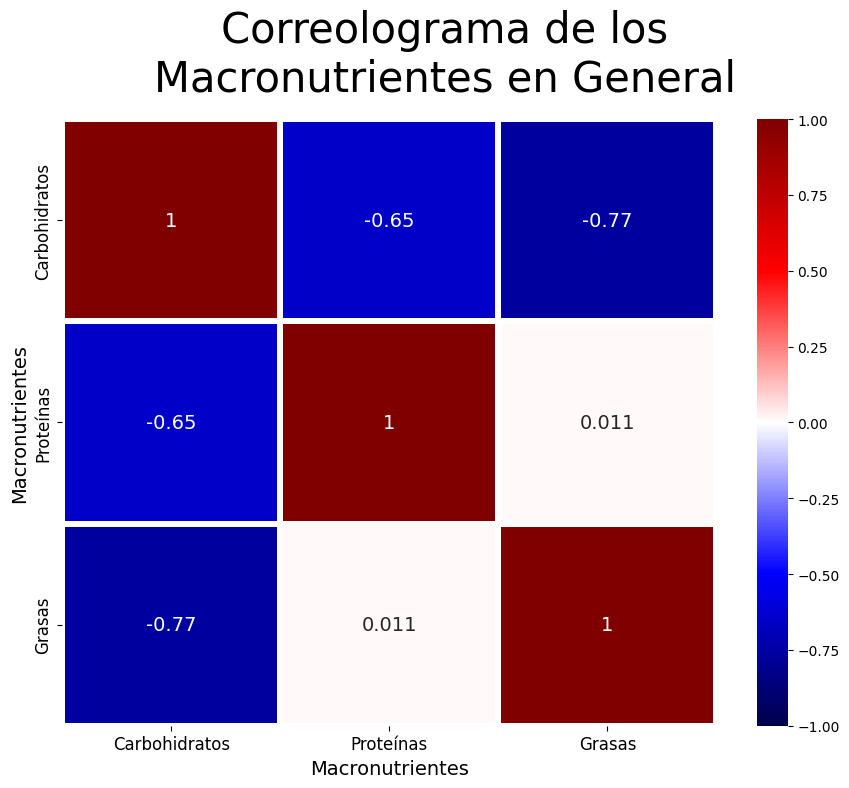

In [200]:
PlotMacronutrientsCorreologram(Diets_Dataset)

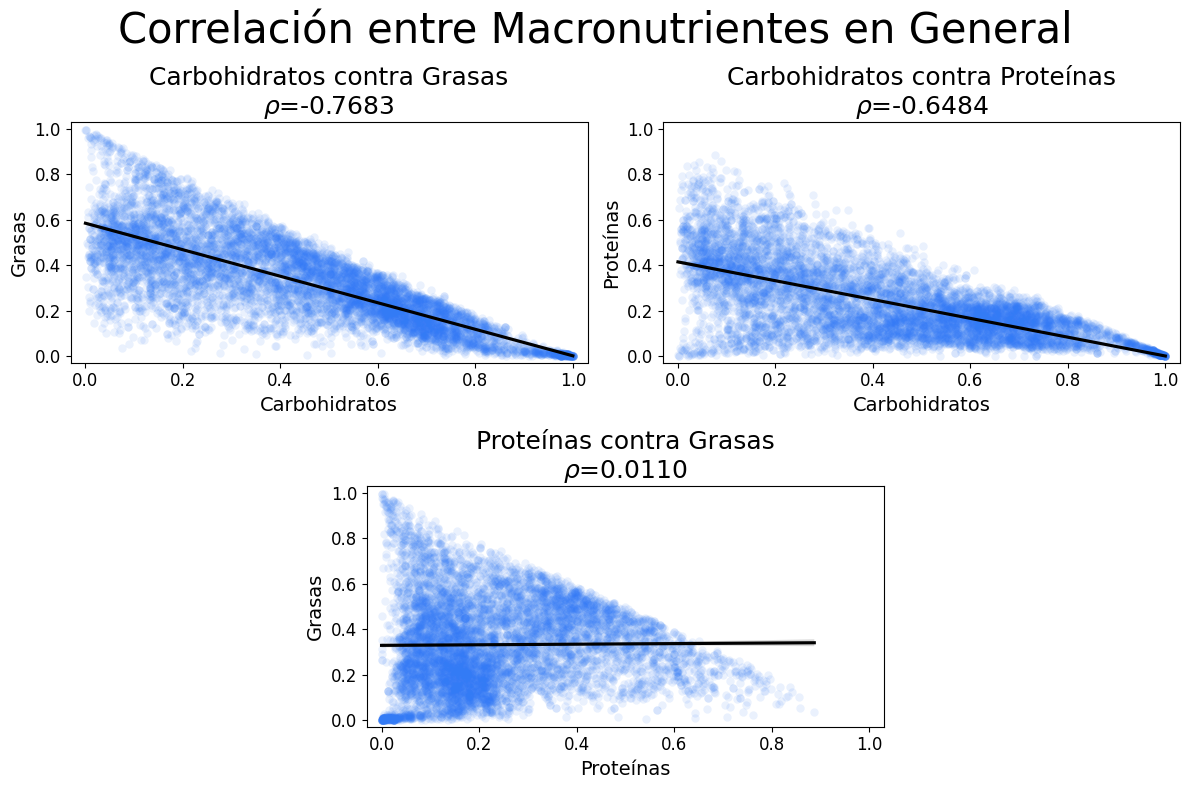

In [221]:
Plot_BiMacronutrients(Diets_Dataset)